# **Import libraries**

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

import spacy
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob, Word, Blobber
from textblob.taggers import NLTKTagger

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

import emoji

from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess

In [2]:
#upload CSV
reviews = pd.read_csv('/Users/jaz/Desktop/Capstone/shopee_reviews.csv', low_memory=False)

# **Explore dataset**

In [3]:
reviews.shape

(1502575, 2)

In [4]:
reviews['label'].value_counts() # Discovered duplicate row

label
5        1303932
4         102129
3          49083
1          28354
2          19076
label          1
Name: count, dtype: int64

### Remove duplicate row

In [5]:
reviews[reviews['label'] == 'label'] # Check row number

label  text
1431262  label  text

In [6]:
reviews = reviews.drop(1431262) # Delete row 1431262

In [7]:
reviews.shape

(1502574, 2)

In [8]:
reviews['label'].value_counts()

label
5    1303932
4     102129
3      49083
1      28354
2      19076
Name: count, dtype: int64

In [9]:
reviews['label'] = reviews['label'].astype(int)
reviews['label'].dtype

dtype('int64')

### Check for empty cells

In [10]:
# Check for empty cells in 'text' column
reviews['text'].isnull().sum()

1

In [11]:
# Check which cell is 'empty'
reviews[reviews['text'].isnull()]

label text
727      5  NaN

In [12]:
# Delete row 727 to avoid confusion
reviews = reviews.drop(index=727)

# Check for empty cells in 'text' column
reviews['text'].isnull().sum()

0

### Removing line breaks

In [13]:
# Check for '\n' or '\r' in the 'text' column
# reviews['has_line_break'] = reviews['text'].apply(lambda review: '\n' in review or '\r' in review)
reviews['has_line_break'] = reviews['text'].str.contains('\n')
reviews['has_line_break'].value_counts()

has_line_break
False    1383528
True      119045
Name: count, dtype: int64

In [14]:
# Check how the line breaks are structured in the text
check_line_break = reviews[reviews['has_line_break'] == True]
check_line_break

label                                               text  \
9            1  Item doesn’t work . \n\nAsked me to send a ref...   
37           5  Product received in good condition.\nThe elect...   
41           5                             Thanks for the item \n   
42           5                                       No bad use\n   
44           5  Item received as stated. Hope it works, will t...   
...        ...                                                ...   
1502532      5                     Very good shoe \nLong lasting    
1502535      5  Even though the item received with dented and ...   
1502541      5  measurements are kinda confusing due to differ...   
1502553      5  Fast deliver, nice material and base!!\nIn law...   
1502570      5  Tried and it fit nicely will buy \nFast and go...   

         has_line_break  
9                  True  
37                 True  
41                 True  
42                 True  
44                 True  
...                 ...  
1502532            True  
1502535            True  
1502541            True  
1502553            True  
1502570            True  

[119045 rows x 3 columns]

In [15]:
# Some line breaks follow a second sentence. Some don't.
# Replace \n and \r with ' ' to avoid two words combining into one.

reviews['text'] = reviews['text'].replace('\\n', ' ', regex=True)

# Test on 1 row
reviews['text'][9]

'Item doesn’t work .   Asked me to send a refund , show a non working machine and deem not enough evidence .   Don’t waste time buying . '

In [16]:
reviews['has_line_break'] = reviews['text'].str.contains('\n')
reviews['has_line_break'].value_counts()

has_line_break
False    1502573
Name: count, dtype: int64

In [17]:
# Check that line breaks are removed
check_line_break = reviews[reviews['has_line_break'] == True]
check_line_break

Empty DataFrame
Columns: [label, text, has_line_break]
Index: []

In [18]:
reviews = reviews.drop(columns='has_line_break')

## Emojis

In [19]:
def count_emojis_in_text(s: str) -> int:
    """
    Count how many characters in the string `s` are recognized as emojis.
    We use `emoji.EMOJI_DATA` as the reference for all valid emoji codepoints.
    """
    if not isinstance(s, str):
        return 0
    count = 0
    for char in s:
        if char in emoji.EMOJI_DATA:
            count += 1
    return count

# Now apply it to your text column
reviews['emoji_count'] = reviews['text'].apply(count_emojis_in_text)

# Inspect the new column
print(reviews[['text', 'emoji_count']].head(10))

                                                text  emoji_count
0  Looks ok. Not like so durable. Will hv to use ...            0
1  Tried, the current can be very powerful depend...            0
2  Item received after a week. Looks smaller than...            0
3  Thanks!!! Works as describe no complaints. Not...            0
4  Fast delivery considering it’s from overseas a...            0
5                        Fast delivery good service             0
6  Got my order and it came well packaged. Have y...            0
7  Items received in a nice box. Have not used it...            0
8  Received in good condition, tried so far so go...            0
9  Item doesn’t work .   Asked me to send a refun...            0


In [20]:
# Total number of emojis used
total_emojis = reviews["emoji_count"].sum()
print(f"Total number of emoji characters in all reviews: {total_emojis}")

Total number of emoji characters in all reviews: 392065


In [21]:
# Reviews with at least 1 emoji
num_with_emoji = (reviews["emoji_count"] > 0).sum()
print(f"Number of reviews containing ≥1 emoji: {num_with_emoji}")

Number of reviews containing ≥1 emoji: 127990


## **Drop reviews with characters < 50**

In [22]:
# Word count on original review
reviews['word_count'] = reviews['text'].apply(lambda text: len(str(text).split()))
reviews

label                                               text  \
0            5  Looks ok. Not like so durable. Will hv to use ...   
1            5  Tried, the current can be very powerful depend...   
2            5  Item received after a week. Looks smaller than...   
3            5  Thanks!!! Works as describe no complaints. Not...   
4            5  Fast delivery considering it’s from overseas a...   
...        ...                                                ...   
1502570      5  Tried and it fit nicely will buy  Fast and goo...   
1502571      5  It's a fantastic product. Very reasonable pric...   
1502572      5  Nice pair of shoes for a gd price. Note the cu...   
1502573      1  Leather?   Rubbish....moulded plastic. What a ...   
1502574      3  Your size 41 smaller than normal, more like si...   

         emoji_count  word_count  
0                  0          18  
1                  0          32  
2                  0          13  
3                  0          15  
4                  0          16  
...              ...         ...  
1502570            0          13  
1502571            0          33  
1502572            0          40  
1502573            0          15  
1502574            0          10  

[1502573 rows x 4 columns]

In [23]:
# Character count on original review
reviews['char_count'] = reviews['text'].apply(lambda text: len(text))
reviews

label                                               text  \
0            5  Looks ok. Not like so durable. Will hv to use ...   
1            5  Tried, the current can be very powerful depend...   
2            5  Item received after a week. Looks smaller than...   
3            5  Thanks!!! Works as describe no complaints. Not...   
4            5  Fast delivery considering it’s from overseas a...   
...        ...                                                ...   
1502570      5  Tried and it fit nicely will buy  Fast and goo...   
1502571      5  It's a fantastic product. Very reasonable pric...   
1502572      5  Nice pair of shoes for a gd price. Note the cu...   
1502573      1  Leather?   Rubbish....moulded plastic. What a ...   
1502574      3  Your size 41 smaller than normal, more like si...   

         emoji_count  word_count  char_count  
0                  0          18          87  
1                  0          32         168  
2                  0          13          75  
3                  0          15         101  
4                  0          16          97  
...              ...         ...         ...  
1502570            0          13          63  
1502571            0          33         206  
1502572            0          40         192  
1502573            0          15         102  
1502574            0          10          51  

[1502573 rows x 5 columns]

In [24]:
# Filter off reviews with char_count < 50
reviews = reviews[reviews['char_count'] >= 50].reset_index(drop=True)
reviews

label                                               text  \
0            5  Looks ok. Not like so durable. Will hv to use ...   
1            5  Tried, the current can be very powerful depend...   
2            5  Item received after a week. Looks smaller than...   
3            5  Thanks!!! Works as describe no complaints. Not...   
4            5  Fast delivery considering it’s from overseas a...   
...        ...                                                ...   
1160714      5  Tried and it fit nicely will buy  Fast and goo...   
1160715      5  It's a fantastic product. Very reasonable pric...   
1160716      5  Nice pair of shoes for a gd price. Note the cu...   
1160717      1  Leather?   Rubbish....moulded plastic. What a ...   
1160718      3  Your size 41 smaller than normal, more like si...   

         emoji_count  word_count  char_count  
0                  0          18          87  
1                  0          32         168  
2                  0          13          75  
3                  0          15         101  
4                  0          16          97  
...              ...         ...         ...  
1160714            0          13          63  
1160715            0          33         206  
1160716            0          40         192  
1160717            0          15         102  
1160718            0          10          51  

[1160719 rows x 5 columns]

In [25]:
reviews['word_count'].mean()

18.227370276526877

In [26]:
reviews['char_count'].mean()

103.02159523536704

### See distribution of ratings
(after removing duplicate row)

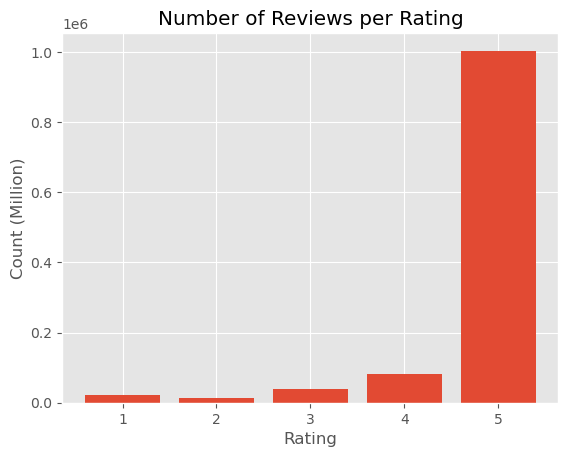

In [27]:
label_counts = reviews['label'].value_counts()

plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Rating')
plt.ylabel('Count (Million)')
plt.title('Number of Reviews per Rating')
plt.show()

In [28]:
reviews['label'].value_counts(normalize=True)

label
5    0.864699
4    0.071497
3    0.032877
1    0.018501
2    0.012425
Name: proportion, dtype: float64

# **Proof of Concept: Modelling on small sample size**

In [29]:
sample = reviews[:2000]

In [30]:
sample

label                                               text  emoji_count  \
0         5  Looks ok. Not like so durable. Will hv to use ...            0   
1         5  Tried, the current can be very powerful depend...            0   
2         5  Item received after a week. Looks smaller than...            0   
3         5  Thanks!!! Works as describe no complaints. Not...            0   
4         5  Fast delivery considering it’s from overseas a...            0   
...     ...                                                ...          ...   
1995      5  Works really well and thanks for all the free ...            0   
1996      5  Item received ...................... n  . .......            0   
1997      5  Received in good condition and everything work...            0   
1998      5  Good deal but not happy that your courier mark...            0   
1999      3  Fast delivery but with a few cracks here and t...            0   

      word_count  char_count  
0             18          87  
1             32         168  
2             13          75  
3             15         101  
4             16          97  
...          ...         ...  
1995          21          98  
1996           6          57  
1997          12          73  
1998          17          97  
1999          10          51  

[2000 rows x 5 columns]

## **Clean Reviews**

In [31]:
nlp = spacy.load("en_core_web_sm")

#### Create custom stopwords list

In [32]:
stop_words = stopwords.words('english')

# See how many there are
print(f"Number of English stopwords: {len(stop_words)}")

# Print them all
print(stop_words)

Number of English stopwords: 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's

In [33]:
custom_sw = set(stopwords.words('english'))

# remove stopwords that may relate to not trying the product yet or comprehensiveness of review

to_keep = {
    'not', 'no', # plain negation
    'don', "don't", # negative sentiment e.g. 'i don't like it'
    'can', # e.g 'can't wait to try'
    'didn', "didn't", # e.g 'didn't try yet'
    'haven', "haven't", # e.g. 'haven't tried'
    'will', # e.g. 'will buy again'
    'again', # e.g. 'will buy again'
    'just', # e.g. 'just arrived'
    'because', # indicates comprehensiveness
    'more', # highlights sentiment
    'should', # may indicate that product is not used 'should be good'
    'few', 'more', # indication of times purchased 'bought a few times': local slang
    'to' # eg. gives 'yet to try' more context
}

custom_sw.difference_update(to_keep)

# add domain-specific stopwords that do not add value to review

custom_sw.update(['item','product'])
print(custom_sw)

{'re', 'nor', "you're", 'his', "you'll", 'very', 'during', 'her', 'between', "he'd", 'shouldn', 'was', 'now', "i'll", "you've", 'the', 's', 'so', "i'd", 'most', 'over', 'i', 'its', "you'd", 'through', 'wouldn', 'a', 'y', 'ourselves', 'up', 'until', 'me', 'herself', 'hadn', 'item', 'with', 'mustn', "they're", 'only', 'yourself', 'these', 'yours', 'll', 'won', 'hasn', 'whom', 'our', 'as', 'at', 'm', 'having', 'down', 'weren', 'had', "it's", 'him', 'after', 'ours', 'them', 'those', "weren't", "they'd", 'here', 'your', "aren't", "i'm", "she's", 'itself', "it'll", 'under', 'has', 'did', 'that', 'but', 'then', 'into', "doesn't", "we'd", "wasn't", 'd', 'against', "couldn't", 'this', 'how', 'doing', 'aren', 'am', "needn't", "shouldn't", "that'll", "i've", 'or', 'hers', 'being', "she'll", 't', 'above', "wouldn't", 'below', 'yourselves', 'are', 'mightn', 've', 'wasn', 'while', "isn't", 'theirs', 'off', 'ma', 'both', 'himself', 'own', 'they', 'ain', 'my', 'needn', "we've", 'o', 'what', 'product',

#### Tokenize, remove stopwords, lemmatize

In [34]:
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = custom_sw
    tokens = [word for word in tokens if word not in stop_words]
    doc = nlp(" ".join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]
    return " ".join(lemmatized_tokens)

In [35]:
sample.loc[:,'cleaned_reviews'] = sample['text'].apply(preprocess_text)
sample

/var/folders/_s/lfbq231x0vld26yhlh8vyfg40000gn/T/ipykernel_25023/2791407652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[:,'cleaned_reviews'] = sample['text'].apply(preprocess_text)


label                                               text  emoji_count  \
0         5  Looks ok. Not like so durable. Will hv to use ...            0   
1         5  Tried, the current can be very powerful depend...            0   
2         5  Item received after a week. Looks smaller than...            0   
3         5  Thanks!!! Works as describe no complaints. Not...            0   
4         5  Fast delivery considering it’s from overseas a...            0   
...     ...                                                ...          ...   
1995      5  Works really well and thanks for all the free ...            0   
1996      5  Item received ...................... n  . .......            0   
1997      5  Received in good condition and everything work...            0   
1998      5  Good deal but not happy that your courier mark...            0   
1999      3  Fast delivery but with a few cracks here and t...            0   

      word_count  char_count  \
0             18          87   
1             32         168   
2             13          75   
3             15         101   
4             16          97   
...          ...         ...   
1995          21          98   
1996           6          57   
1997          12          73   
1998          17          97   
1999          10          51   

                                        cleaned_reviews  
0     look ok . not like durable . will hv to use to...  
1     try , current can powerful depend setting , no...  
2     receive week . look small expect , can ' wait ...  
3     thanks ! ! ! work describe no complaint . not ...  
4     fast delivery consider ' overseas try . not su...  
...                                                 ...  
1995  work really well thank free gift : ) hope to p...  
1996  receive ...................... n . ..............  
1997  receive good condition everything work per sta...  
1998  good deal not happy courier marked deliver few...  
1999                            fast delivery few crack  

[2000 rows x 6 columns]

In [36]:
## Export to CSV to check
# sample.to_csv('sample.csv')

## **Add column to detect if product has been used**
Usefulness of review may depend on whether product has been used before reviewing.

In [37]:
unhelpful_patterns = [
    r"(?:can(?:not|n't)\s+wait\s+to\s+(?:try|use))", # “cant/ can not wait to try” or “cant/ can not wait to use” 
    r"(?:\bwait\s+to\s+try\b)", # “wait to try” (without “can”)
    r"(?:\byet\s+to\s+try\b)", # “yet to try”
    r"(?:\bupdate(?:\s+again)?\s+after\s+trying\b)", # “update again after trying” or “update after trying”
    r"(?:\bhave\s+not\s+tr(?:y|ied)\b)", # “have not try/ tried”
    r"(?:\bhaven'?t\s+tr(?:y|ied)\b)",# “haven't tried/ havent tried”
    r"(?:\byet\s+to\s+use\b)", # “yet to use”
    r"(?:\bnot\s+yet\s+test(?:ed)?\b)", # “not yet tested” (“tested” optional “-ed”)
    r"(?:\bhaven'?t\s+test(?:ed)?\s+yet\b)", # “haven't tested yet” / “havent tested yet”
    r"(?:\b(?:will\s+)?test\s+soon\b)", # "(will) test soon”
    r"(?:\b(?:will\s+)?try\s+soon\b)", # “(will) try soon”
    r"(?:\byet\b)", # standalone “yet” (word‐boundary)
    r"(?:\bhopefully(?:\s+it)?\s+works?\b)", # “hopefully it works” / “hopefully works”
    r"(?:\bhoping\s+it\s+works\b)", # “hoping it works”
    r"(?:\bhope(?:\s+it)?\s+works?\b)", # “hope it works” / “hope it works well” (covers “hope” + “works”)
]

# Compile combined regex pattern (case-insensitive)
combined_pattern = re.compile(
    '(' + '|'.join(unhelpful_patterns) + ')',
    flags=re.IGNORECASE
)

def label_not_tried(text):
    if not isinstance(text, str) or not text.strip():
        return False
    t = text.lower()
    return bool(combined_pattern.search(t))

sample.loc[:,'not_tried'] = sample['cleaned_reviews'].apply(label_not_tried)
sample

/var/folders/_s/lfbq231x0vld26yhlh8vyfg40000gn/T/ipykernel_25023/2050559884.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[:,'not_tried'] = sample['cleaned_reviews'].apply(label_not_tried)


label                                               text  emoji_count  \
0         5  Looks ok. Not like so durable. Will hv to use ...            0   
1         5  Tried, the current can be very powerful depend...            0   
2         5  Item received after a week. Looks smaller than...            0   
3         5  Thanks!!! Works as describe no complaints. Not...            0   
4         5  Fast delivery considering it’s from overseas a...            0   
...     ...                                                ...          ...   
1995      5  Works really well and thanks for all the free ...            0   
1996      5  Item received ...................... n  . .......            0   
1997      5  Received in good condition and everything work...            0   
1998      5  Good deal but not happy that your courier mark...            0   
1999      3  Fast delivery but with a few cracks here and t...            0   

      word_count  char_count  \
0             18          87   
1             32         168   
2             13          75   
3             15         101   
4             16          97   
...          ...         ...   
1995          21          98   
1996           6          57   
1997          12          73   
1998          17          97   
1999          10          51   

                                        cleaned_reviews  not_tried  
0     look ok . not like durable . will hv to use to...      False  
1     try , current can powerful depend setting , no...      False  
2     receive week . look small expect , can ' wait ...       True  
3     thanks ! ! ! work describe no complaint . not ...      False  
4     fast delivery consider ' overseas try . not su...       True  
...                                                 ...        ...  
1995  work really well thank free gift : ) hope to p...      False  
1996  receive ...................... n . ..............      False  
1997  receive good condition everything work per sta...      False  
1998  good deal not happy courier marked deliver few...      False  
1999                            fast delivery few crack      False  

[2000 rows x 7 columns]

In [38]:
unhelpful_patterns = [
    r"(?:can(?:not|n't)\s+wait\s+to\s+(?:try|use))", # “cant/ can not wait to try” or “cant/ can not wait to use” 
    r"(?:\bwait\s+to\s+try\b)", # “wait to try” (without “can”)
    r"(?:\byet\s+to\s+try\b)", # “yet to try”
    r"(?:\bupdate(?:\s+again)?\s+after\s+trying\b)", # “update again after trying” or “update after trying”
    r"(?:\bhave\s+not\s+tr(?:y|ied)\b)", # “have not try/ tried”
    r"(?:\bhaven'?t\s+tr(?:y|ied)\b)",# “haven't tried/ havent tried”
    r"(?:\byet\s+to\s+use\b)", # “yet to use”
    r"(?:\bnot\s+yet\s+test(?:ed)?\b)", # “not yet tested” (“tested” optional “-ed”)
    r"(?:\bhaven'?t\s+test(?:ed)?\s+yet\b)", # “haven't tested yet” / “havent tested yet”
    r"(?:\b(?:will\s+)?test\s+soon\b)", # "(will) test soon”
    r"(?:\b(?:will\s+)?try\s+soon\b)", # “(will) try soon”
    r"(?:\byet\b)", # standalone “yet” (word‐boundary)
    r"(?:\bhopefully(?:\s+it)?\s+works?\b)", # “hopefully it works” / “hopefully works”
    r"(?:\bhoping\s+it\s+works\b)", # “hoping it works”
    r"(?:\bhope(?:\s+it)?\s+works?\b)", # “hope it works” / “hope it works well” (covers “hope” + “works”)
]

# Compile combined regex pattern (case-insensitive)
combined_pattern = re.compile(
    '(' + '|'.join(unhelpful_patterns) + ')',
    flags=re.IGNORECASE
)

def label_not_tried(text):
    if not isinstance(text, str) or not text.strip():
        return False
    t = text.lower()
    return bool(combined_pattern.search(t))

sample.loc[:,'not_tried'] = sample['cleaned_reviews'].apply(label_not_tried)
sample

label                                               text  emoji_count  \
0         5  Looks ok. Not like so durable. Will hv to use ...            0   
1         5  Tried, the current can be very powerful depend...            0   
2         5  Item received after a week. Looks smaller than...            0   
3         5  Thanks!!! Works as describe no complaints. Not...            0   
4         5  Fast delivery considering it’s from overseas a...            0   
...     ...                                                ...          ...   
1995      5  Works really well and thanks for all the free ...            0   
1996      5  Item received ...................... n  . .......            0   
1997      5  Received in good condition and everything work...            0   
1998      5  Good deal but not happy that your courier mark...            0   
1999      3  Fast delivery but with a few cracks here and t...            0   

      word_count  char_count  \
0             18          87   
1             32         168   
2             13          75   
3             15         101   
4             16          97   
...          ...         ...   
1995          21          98   
1996           6          57   
1997          12          73   
1998          17          97   
1999          10          51   

                                        cleaned_reviews  not_tried  
0     look ok . not like durable . will hv to use to...      False  
1     try , current can powerful depend setting , no...      False  
2     receive week . look small expect , can ' wait ...       True  
3     thanks ! ! ! work describe no complaint . not ...      False  
4     fast delivery consider ' overseas try . not su...       True  
...                                                 ...        ...  
1995  work really well thank free gift : ) hope to p...      False  
1996  receive ...................... n . ..............      False  
1997  receive good condition everything work per sta...      False  
1998  good deal not happy courier marked deliver few...      False  
1999                            fast delivery few crack      False  

[2000 rows x 7 columns]

In [39]:
sample['not_tried'].value_counts()
# 8% of total reviews indicate product not tried before reviewing

not_tried
False    1846
True      154
Name: count, dtype: int64

## **Sentiment Analysis (Vader)**
Apply sentiment analysis to understand how positive or negative a review is

In [40]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jaz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [41]:
sia = SentimentIntensityAnalyzer()

def vader_sentiment_polarity(text):
    senti = sia.polarity_scores(text)
    return senti

In [42]:
sample.loc[:,'sentiment_polarity'] = sample['cleaned_reviews'].apply(vader_sentiment_polarity)
sample

/var/folders/_s/lfbq231x0vld26yhlh8vyfg40000gn/T/ipykernel_25023/1578725169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[:,'sentiment_polarity'] = sample['cleaned_reviews'].apply(vader_sentiment_polarity)


label                                               text  emoji_count  \
0         5  Looks ok. Not like so durable. Will hv to use ...            0   
1         5  Tried, the current can be very powerful depend...            0   
2         5  Item received after a week. Looks smaller than...            0   
3         5  Thanks!!! Works as describe no complaints. Not...            0   
4         5  Fast delivery considering it’s from overseas a...            0   
...     ...                                                ...          ...   
1995      5  Works really well and thanks for all the free ...            0   
1996      5  Item received ...................... n  . .......            0   
1997      5  Received in good condition and everything work...            0   
1998      5  Good deal but not happy that your courier mark...            0   
1999      3  Fast delivery but with a few cracks here and t...            0   

      word_count  char_count  \
0             18          87   
1             32         168   
2             13          75   
3             15         101   
4             16          97   
...          ...         ...   
1995          21          98   
1996           6          57   
1997          12          73   
1998          17          97   
1999          10          51   

                                        cleaned_reviews  not_tried  \
0     look ok . not like durable . will hv to use to...      False   
1     try , current can powerful depend setting , no...      False   
2     receive week . look small expect , can ' wait ...       True   
3     thanks ! ! ! work describe no complaint . not ...      False   
4     fast delivery consider ' overseas try . not su...       True   
...                                                 ...        ...   
1995  work really well thank free gift : ) hope to p...      False   
1996  receive ...................... n . ..............      False   
1997  receive good condition everything work per sta...      False   
1998  good deal not happy courier marked deliver few...      False   
1999                            fast delivery few crack      False   

                                     sentiment_polarity  
0     {'neg': 0.119, 'neu': 0.508, 'pos': 0.373, 'co...  
1     {'neg': 0.094, 'neu': 0.714, 'pos': 0.192, 'co...  
2     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
3     {'neg': 0.232, 'neu': 0.422, 'pos': 0.346, 'co...  
4     {'neg': 0.197, 'neu': 0.803, 'pos': 0.0, 'comp...  
...                                                 ...  
1995  {'neg': 0.0, 'neu': 0.283, 'pos': 0.717, 'comp...  
1996  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
1997  {'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...  
1998  {'neg': 0.201, 'neu': 0.604, 'pos': 0.195, 'co...  
1999  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  

[2000 rows x 8 columns]

### Extract scores into columns

In [43]:
sample.loc[:,['neg','neu','pos','compound']] = sample['sentiment_polarity'].apply(pd.Series)
sample

label                                               text  emoji_count  \
0         5  Looks ok. Not like so durable. Will hv to use ...            0   
1         5  Tried, the current can be very powerful depend...            0   
2         5  Item received after a week. Looks smaller than...            0   
3         5  Thanks!!! Works as describe no complaints. Not...            0   
4         5  Fast delivery considering it’s from overseas a...            0   
...     ...                                                ...          ...   
1995      5  Works really well and thanks for all the free ...            0   
1996      5  Item received ...................... n  . .......            0   
1997      5  Received in good condition and everything work...            0   
1998      5  Good deal but not happy that your courier mark...            0   
1999      3  Fast delivery but with a few cracks here and t...            0   

      word_count  char_count  \
0             18          87   
1             32         168   
2             13          75   
3             15         101   
4             16          97   
...          ...         ...   
1995          21          98   
1996           6          57   
1997          12          73   
1998          17          97   
1999          10          51   

                                        cleaned_reviews  not_tried  \
0     look ok . not like durable . will hv to use to...      False   
1     try , current can powerful depend setting , no...      False   
2     receive week . look small expect , can ' wait ...       True   
3     thanks ! ! ! work describe no complaint . not ...      False   
4     fast delivery consider ' overseas try . not su...       True   
...                                                 ...        ...   
1995  work really well thank free gift : ) hope to p...      False   
1996  receive ...................... n . ..............      False   
1997  receive good condition everything work per sta...      False   
1998  good deal not happy courier marked deliver few...      False   
1999                            fast delivery few crack      False   

                                     sentiment_polarity    neg    neu    pos  \
0     {'neg': 0.119, 'neu': 0.508, 'pos': 0.373, 'co...  0.119  0.508  0.373   
1     {'neg': 0.094, 'neu': 0.714, 'pos': 0.192, 'co...  0.094  0.714  0.192   
2     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000  1.000  0.000   
3     {'neg': 0.232, 'neu': 0.422, 'pos': 0.346, 'co...  0.232  0.422  0.346   
4     {'neg': 0.197, 'neu': 0.803, 'pos': 0.0, 'comp...  0.197  0.803  0.000   
...                                                 ...    ...    ...    ...   
1995  {'neg': 0.0, 'neu': 0.283, 'pos': 0.717, 'comp...  0.000  0.283  0.717   
1996  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000  1.000  0.000   
1997  {'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...  0.000  0.423  0.577   
1998  {'neg': 0.201, 'neu': 0.604, 'pos': 0.195, 'co...  0.201  0.604  0.195   
1999  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000  1.000  0.000   

      compound  
0       0.5408  
1       0.3818  
2       0.0000  
3       0.4885  
4      -0.2411  
...        ...  
1995    0.9496  
1996    0.0000  
1997    0.8020  
1998   -0.0253  
1999    0.0000  

[2000 rows x 12 columns]

# **Classify reviews into useful and not useful as labels**

In [44]:
score = sample['compound']
not_tried = sample['not_tried']
def classify_usefulness(score, not_tried):
    if not_tried == True:
        verdict = 'not_useful'
    elif abs(score) > 0.1:
        verdict = 'useful'
    else:
        verdict = 'not_useful'
    return verdict

In [45]:
sample.loc[:,'verdict'] = sample.apply(lambda row: classify_usefulness(row['compound'], row['not_tried']), axis=1)

sample

/var/folders/_s/lfbq231x0vld26yhlh8vyfg40000gn/T/ipykernel_25023/3739543606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[:,'verdict'] = sample.apply(lambda row: classify_usefulness(row['compound'], row['not_tried']), axis=1)


label                                               text  emoji_count  \
0         5  Looks ok. Not like so durable. Will hv to use ...            0   
1         5  Tried, the current can be very powerful depend...            0   
2         5  Item received after a week. Looks smaller than...            0   
3         5  Thanks!!! Works as describe no complaints. Not...            0   
4         5  Fast delivery considering it’s from overseas a...            0   
...     ...                                                ...          ...   
1995      5  Works really well and thanks for all the free ...            0   
1996      5  Item received ...................... n  . .......            0   
1997      5  Received in good condition and everything work...            0   
1998      5  Good deal but not happy that your courier mark...            0   
1999      3  Fast delivery but with a few cracks here and t...            0   

      word_count  char_count  \
0             18          87   
1             32         168   
2             13          75   
3             15         101   
4             16          97   
...          ...         ...   
1995          21          98   
1996           6          57   
1997          12          73   
1998          17          97   
1999          10          51   

                                        cleaned_reviews  not_tried  \
0     look ok . not like durable . will hv to use to...      False   
1     try , current can powerful depend setting , no...      False   
2     receive week . look small expect , can ' wait ...       True   
3     thanks ! ! ! work describe no complaint . not ...      False   
4     fast delivery consider ' overseas try . not su...       True   
...                                                 ...        ...   
1995  work really well thank free gift : ) hope to p...      False   
1996  receive ...................... n . ..............      False   
1997  receive good condition everything work per sta...      False   
1998  good deal not happy courier marked deliver few...      False   
1999                            fast delivery few crack      False   

                                     sentiment_polarity    neg    neu    pos  \
0     {'neg': 0.119, 'neu': 0.508, 'pos': 0.373, 'co...  0.119  0.508  0.373   
1     {'neg': 0.094, 'neu': 0.714, 'pos': 0.192, 'co...  0.094  0.714  0.192   
2     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000  1.000  0.000   
3     {'neg': 0.232, 'neu': 0.422, 'pos': 0.346, 'co...  0.232  0.422  0.346   
4     {'neg': 0.197, 'neu': 0.803, 'pos': 0.0, 'comp...  0.197  0.803  0.000   
...                                                 ...    ...    ...    ...   
1995  {'neg': 0.0, 'neu': 0.283, 'pos': 0.717, 'comp...  0.000  0.283  0.717   
1996  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000  1.000  0.000   
1997  {'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...  0.000  0.423  0.577   
1998  {'neg': 0.201, 'neu': 0.604, 'pos': 0.195, 'co...  0.201  0.604  0.195   
1999  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000  1.000  0.000   

      compound     verdict  
0       0.5408      useful  
1       0.3818      useful  
2       0.0000  not_useful  
3       0.4885      useful  
4      -0.2411  not_useful  
...        ...         ...  
1995    0.9496      useful  
1996    0.0000  not_useful  
1997    0.8020      useful  
1998   -0.0253  not_useful  
1999    0.0000  not_useful  

[2000 rows x 13 columns]

In [46]:
# Export to CSV to check
sample.to_csv('sample_sentiment_usefulness.csv')

In [47]:
# Manually correct wrong labels and read file
## Reviews that describe some form of comprehension about the product were corrected to 'useful'
corrected_sample = pd.read_csv('/Users/jaz/Desktop/Capstone/final_corrected_sample_sentiment_usefulness.csv')

# Train Test Split

In [51]:
df_train, df_test = train_test_split(
    corrected_sample,
    test_size=400,
    random_state=42,
    stratify=corrected_sample['verdict']
)
df_train # 1600 rows

Unnamed: 0  label                                               text  \
1668        1668      4  Item came after a while but product looks pret...   
1793        1793      5  Item received in good packaging. Hope its as g...   
119          119      5  Product was packaged really nicely. Seemed to ...   
1182        1182      5  bought the  blue one! its good and was deliver...   
1456        1456      5  love the bottle, looks exactly the same as in ...   
...          ...    ...                                                ...   
18            18      5  was given a replacement pack, because the one ...   
1046        1046      5  Fast delivery, item was received in a week and...   
171          171      4  Looks cute & all but back part rides up like s...   
806          806      5  Item received well. Quality as per picture. Cu...   
1722        1722      5  Item came in good condition. Well packaged and...   

      emoji_count  word_count  char_count  \
1668            0          14          73   
1793            0          11          63   
119             0          16          93   
1182            0          12          69   
1456            0          11          58   
...           ...         ...         ...   
18              0          15          78   
1046            2          14          70   
171             0          17          89   
806             0          10          65   
1722            0          10          63   

                                        cleaned_reviews  not_tried  \
1668                  come look pretty legit thank much      False   
1793        receive good packaging . hope god advertise      False   
119   package really nicely . seem to work well swit...      False   
1182    buy blue one ! good deliver fast . appreciate !      False   
1456               love bottle , look exactly picture .      False   
...                                                 ...        ...   
18    give replacement pack , because one faulty , t...      False   
1046       fast delivery , receive week nicely pack 👍 🏻      False   
171   look cute & back part ride like other say , al...      False   
806   receive well . quality per picture . cushion q...      False   
1722  come good condition . well package smooth deli...      False   

                                     sentiment_polarity    neg    neu    pos  \
1668  {'neg': 0.0, 'neu': 0.412, 'pos': 0.588, 'comp...  0.000  0.412  0.588   
1793  {'neg': 0.0, 'neu': 0.275, 'pos': 0.725, 'comp...  0.000  0.275  0.725   
119   {'neg': 0.0, 'neu': 0.569, 'pos': 0.431, 'comp...  0.000  0.569  0.431   
1182  {'neg': 0.0, 'neu': 0.447, 'pos': 0.553, 'comp...  0.000  0.447  0.553   
1456  {'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'comp...  0.000  0.488  0.512   
...                                                 ...    ...    ...    ...   
18    {'neg': 0.235, 'neu': 0.51, 'pos': 0.255, 'com...  0.235  0.510  0.255   
1046  {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...  0.000  0.633  0.367   
171   {'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...  0.000  0.621  0.379   
806   {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...  0.000  0.769  0.231   
1722  {'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound...  0.000  0.500  0.500   

      compound verdict  
1668    0.6908  useful  
1793    0.7845  useful  
119     0.6478  useful  
1182    0.7339  useful  
1456    0.6369  useful  
...        ...     ...  
18      0.0516  useful  
1046    0.4404  useful  
171     0.6705  useful  
806     0.2732  useful  
1722    0.6124  useful  

[1600 rows x 14 columns]

In [52]:
# Reset index to create new index for split datasets
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [53]:
# Drop unnamed column '0'
df_train = df_train.drop(columns='Unnamed: 0')
df_test = df_test.drop(columns='Unnamed: 0')

In [54]:
vectorizer1 = TfidfVectorizer(ngram_range=(2,3), min_df=5, max_features=5000)
vectorizer2 = vectorizer1.fit_transform(df_train['cleaned_reviews'])
feature_names = vectorizer1.get_feature_names_out()
df_vectorizer2 = pd.DataFrame(vectorizer2.toarray(), columns=feature_names)
df_vectorizer2.reset_index(drop=True)

10 10  10 day  10 mm  able to  again need  again thank  also come  \
0       0.0     0.0    0.0      0.0         0.0          0.0        0.0   
1       0.0     0.0    0.0      0.0         0.0          0.0        0.0   
2       0.0     0.0    0.0      0.0         0.0          0.0        0.0   
3       0.0     0.0    0.0      0.0         0.0          0.0        0.0   
4       0.0     0.0    0.0      0.0         0.0          0.0        0.0   
...     ...     ...    ...      ...         ...          ...        ...   
1595    0.0     0.0    0.0      0.0         0.0          0.0        0.0   
1596    0.0     0.0    0.0      0.0         0.0          0.0        0.0   
1597    0.0     0.0    0.0      0.0         0.0          0.0        0.0   
1598    0.0     0.0    0.0      0.0         0.0          0.0        0.0   
1599    0.0     0.0    0.0      0.0         0.0          0.0        0.0   

      anti slip  arrive good  bag strap  ...  would not  would recommend  \
0           0.0          0.0        0.0  ...        0.0              0.0   
1           0.0          0.0        0.0  ...        0.0              0.0   
2           0.0          0.0        0.0  ...        0.0              0.0   
3           0.0          0.0        0.0  ...        0.0              0.0   
4           0.0          0.0        0.0  ...        0.0              0.0   
...         ...          ...        ...  ...        ...              ...   
1595        0.0          0.0        0.0  ...        0.0              0.0   
1596        0.0          0.0        0.0  ...        0.0              0.0   
1597        0.0          0.0        0.0  ...        0.0              0.0   
1598        0.0          0.0        0.0  ...        0.0              0.0   
1599        0.0          0.0        0.0  ...        0.0              0.0   

      yesterday receive  yet hope  yet look  yet to  yet to try  yet to use  \
0                   0.0       0.0       0.0     0.0         0.0         0.0   
1                   0.0       0.0       0.0     0.0         0.0         0.0   
2                   0.0       0.0       0.0     0.0         0.0         0.0   
3                   0.0       0.0       0.0     0.0         0.0         0.0   
4                   0.0       0.0       0.0     0.0         0.0         0.0   
...                 ...       ...       ...     ...         ...         ...   
1595                0.0       0.0       0.0     0.0         0.0         0.0   
1596                0.0       0.0       0.0     0.0         0.0         0.0   
1597                0.0       0.0       0.0     0.0         0.0         0.0   
1598                0.0       0.0       0.0     0.0         0.0         0.0   
1599                0.0       0.0       0.0     0.0         0.0         0.0   

      yet try  yoga mat  
0         0.0       0.0  
1         0.0       0.0  
2         0.0       0.0  
3         0.0       0.0  
4         0.0       0.0  
...       ...       ...  
1595      0.0       0.0  
1596      0.0       0.0  
1597      0.0       0.0  
1598      0.0       0.0  
1599      0.0       0.0  

[1600 rows x 509 columns]

In [55]:
df_train = pd.concat([df_train, df_vectorizer2], axis=1)
df_train

label                                               text  emoji_count  \
0         4  Item came after a while but product looks pret...            0   
1         5  Item received in good packaging. Hope its as g...            0   
2         5  Product was packaged really nicely. Seemed to ...            0   
3         5  bought the  blue one! its good and was deliver...            0   
4         5  love the bottle, looks exactly the same as in ...            0   
...     ...                                                ...          ...   
1595      5  was given a replacement pack, because the one ...            0   
1596      5  Fast delivery, item was received in a week and...            2   
1597      4  Looks cute & all but back part rides up like s...            0   
1598      5  Item received well. Quality as per picture. Cu...            0   
1599      5  Item came in good condition. Well packaged and...            0   

      word_count  char_count  \
0             14          73   
1             11          63   
2             16          93   
3             12          69   
4             11          58   
...          ...         ...   
1595          15          78   
1596          14          70   
1597          17          89   
1598          10          65   
1599          10          63   

                                        cleaned_reviews  not_tried  \
0                     come look pretty legit thank much      False   
1           receive good packaging . hope god advertise      False   
2     package really nicely . seem to work well swit...      False   
3       buy blue one ! good deliver fast . appreciate !      False   
4                  love bottle , look exactly picture .      False   
...                                                 ...        ...   
1595  give replacement pack , because one faulty , t...      False   
1596       fast delivery , receive week nicely pack 👍 🏻      False   
1597  look cute & back part ride like other say , al...      False   
1598  receive well . quality per picture . cushion q...      False   
1599  come good condition . well package smooth deli...      False   

                                     sentiment_polarity    neg    neu  ...  \
0     {'neg': 0.0, 'neu': 0.412, 'pos': 0.588, 'comp...  0.000  0.412  ...   
1     {'neg': 0.0, 'neu': 0.275, 'pos': 0.725, 'comp...  0.000  0.275  ...   
2     {'neg': 0.0, 'neu': 0.569, 'pos': 0.431, 'comp...  0.000  0.569  ...   
3     {'neg': 0.0, 'neu': 0.447, 'pos': 0.553, 'comp...  0.000  0.447  ...   
4     {'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'comp...  0.000  0.488  ...   
...                                                 ...    ...    ...  ...   
1595  {'neg': 0.235, 'neu': 0.51, 'pos': 0.255, 'com...  0.235  0.510  ...   
1596  {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...  0.000  0.633  ...   
1597  {'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...  0.000  0.621  ...   
1598  {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...  0.000  0.769  ...   
1599  {'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound...  0.000  0.500  ...   

      would not  would recommend yesterday receive  yet hope  yet look  \
0           0.0              0.0               0.0       0.0       0.0   
1           0.0              0.0               0.0       0.0       0.0   
2           0.0              0.0               0.0       0.0       0.0   
3           0.0              0.0               0.0       0.0       0.0   
4           0.0              0.0               0.0       0.0       0.0   
...         ...              ...               ...       ...       ...   
1595        0.0              0.0               0.0       0.0       0.0   
1596        0.0              0.0               0.0       0.0       0.0   
1597        0.0              0.0               0.0       0.0       0.0   
1598        0.0              0.0               0.0       0.0       0.0   
1599        0.0              0.0               0.0       0.0       0.0   

     

## **Scale rating to match scale of vectorized reviews**

In [56]:
scaler = MinMaxScaler()
df_train['rating_normalized'] = scaler.fit_transform(df_train[['label']])
df_train

label                                               text  emoji_count  \
0         4  Item came after a while but product looks pret...            0   
1         5  Item received in good packaging. Hope its as g...            0   
2         5  Product was packaged really nicely. Seemed to ...            0   
3         5  bought the  blue one! its good and was deliver...            0   
4         5  love the bottle, looks exactly the same as in ...            0   
...     ...                                                ...          ...   
1595      5  was given a replacement pack, because the one ...            0   
1596      5  Fast delivery, item was received in a week and...            2   
1597      4  Looks cute & all but back part rides up like s...            0   
1598      5  Item received well. Quality as per picture. Cu...            0   
1599      5  Item came in good condition. Well packaged and...            0   

      word_count  char_count  \
0             14          73   
1             11          63   
2             16          93   
3             12          69   
4             11          58   
...          ...         ...   
1595          15          78   
1596          14          70   
1597          17          89   
1598          10          65   
1599          10          63   

                                        cleaned_reviews  not_tried  \
0                     come look pretty legit thank much      False   
1           receive good packaging . hope god advertise      False   
2     package really nicely . seem to work well swit...      False   
3       buy blue one ! good deliver fast . appreciate !      False   
4                  love bottle , look exactly picture .      False   
...                                                 ...        ...   
1595  give replacement pack , because one faulty , t...      False   
1596       fast delivery , receive week nicely pack 👍 🏻      False   
1597  look cute & back part ride like other say , al...      False   
1598  receive well . quality per picture . cushion q...      False   
1599  come good condition . well package smooth deli...      False   

                                     sentiment_polarity    neg    neu  ...  \
0     {'neg': 0.0, 'neu': 0.412, 'pos': 0.588, 'comp...  0.000  0.412  ...   
1     {'neg': 0.0, 'neu': 0.275, 'pos': 0.725, 'comp...  0.000  0.275  ...   
2     {'neg': 0.0, 'neu': 0.569, 'pos': 0.431, 'comp...  0.000  0.569  ...   
3     {'neg': 0.0, 'neu': 0.447, 'pos': 0.553, 'comp...  0.000  0.447  ...   
4     {'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'comp...  0.000  0.488  ...   
...                                                 ...    ...    ...  ...   
1595  {'neg': 0.235, 'neu': 0.51, 'pos': 0.255, 'com...  0.235  0.510  ...   
1596  {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...  0.000  0.633  ...   
1597  {'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...  0.000  0.621  ...   
1598  {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...  0.000  0.769  ...   
1599  {'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound...  0.000  0.500  ...   

      would recommend  yesterday receive yet hope  yet look  yet to  \
0                 0.0                0.0      0.0       0.0     0.0   
1                 0.0                0.0      0.0       0.0     0.0   
2                 0.0                0.0      0.0       0.0     0.0   
3                 0.0                0.0      0.0       0.0     0.0   
4                 0.0                0.0      0.0       0.0     0.0   
...               ...                ...      ...       ...     ...   
1595              0.0                0.0      0.0       0.0     0.0   
1596              0.0                0.0      0.0       0.0     0.0   
1597              0.0                0.0      0.0       0.0     0.0   
1598              0.0                0.0      0.0       0.0     0.0   
1599              0.0                0.0      0.0       0.0     0.0   

      yet to try  yet to use  yet try  yo

In [57]:
X_train = df_train.drop(columns=['label','text','cleaned_reviews','not_tried','sentiment_polarity','word_count','char_count','neg','neu','pos','compound','verdict'])
X_train

emoji_count  10 10  10 day  10 mm  able to  again need  again thank  \
0               0    0.0     0.0    0.0      0.0         0.0          0.0   
1               0    0.0     0.0    0.0      0.0         0.0          0.0   
2               0    0.0     0.0    0.0      0.0         0.0          0.0   
3               0    0.0     0.0    0.0      0.0         0.0          0.0   
4               0    0.0     0.0    0.0      0.0         0.0          0.0   
...           ...    ...     ...    ...      ...         ...          ...   
1595            0    0.0     0.0    0.0      0.0         0.0          0.0   
1596            2    0.0     0.0    0.0      0.0         0.0          0.0   
1597            0    0.0     0.0    0.0      0.0         0.0          0.0   
1598            0    0.0     0.0    0.0      0.0         0.0          0.0   
1599            0    0.0     0.0    0.0      0.0         0.0          0.0   

      also come  anti slip  arrive good  ...  would recommend  \
0           0.0        0.0          0.0  ...              0.0   
1           0.0        0.0          0.0  ...              0.0   
2           0.0        0.0          0.0  ...              0.0   
3           0.0        0.0          0.0  ...              0.0   
4           0.0        0.0          0.0  ...              0.0   
...         ...        ...          ...  ...              ...   
1595        0.0        0.0          0.0  ...              0.0   
1596        0.0        0.0          0.0  ...              0.0   
1597        0.0        0.0          0.0  ...              0.0   
1598        0.0        0.0          0.0  ...              0.0   
1599        0.0        0.0          0.0  ...              0.0   

      yesterday receive  yet hope  yet look  yet to  yet to try  yet to use  \
0                   0.0       0.0       0.0     0.0         0.0         0.0   
1                   0.0       0.0       0.0     0.0         0.0         0.0   
2                   0.0       0.0       0.0     0.0         0.0         0.0   
3                   0.0       0.0       0.0     0.0         0.0         0.0   
4                   0.0       0.0       0.0     0.0         0.0         0.0   
...                 ...       ...       ...     ...         ...         ...   
1595                0.0       0.0       0.0     0.0         0.0         0.0   
1596                0.0       0.0       0.0     0.0         0.0         0.0   
1597                0.0       0.0       0.0     0.0         0.0         0.0   
1598                0.0       0.0       0.0     0.0         0.0         0.0   
1599                0.0       0.0       0.0     0.0         0.0         0.0   

      yet try  yoga mat  rating_normalized  
0         0.0       0.0               0.75  
1         0.0       0.0               1.00  
2         0.0       0.0               1.00  
3         0.0       0.0               1.00  
4         0.0       0.0               1.00  
...       ...       ...                ...  
1595      0.0       0.0               1.00  
1596      0.0       0.0               1.00  
1597      0.0       0.0               0.75  
1598      0.0       0.0               1.00  
1599      0.0       0.0               1.00  

[1600 rows x 511 columns]

In [58]:
# map 'verdict' column to binary values
y_train = df_train['verdict'].map({'not_useful':0, 'useful':1}).astype(float)
y_train

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1595    1.0
1596    1.0
1597    1.0
1598    1.0
1599    1.0
Name: verdict, Length: 1600, dtype: float64

## **Predictive Models**

### Naive Bayes


In [59]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [60]:
nb = MultinomialNB(alpha=1.0)
nb.fit(X_train.values, y_train.values)

y_pred_nb_train = nb.predict(X_train.values)
print("=== Naïve Bayes Classification Report ===")
print(classification_report(y_train.values, y_pred_nb_train, target_names=["not_useful","useful"]))

=== Naïve Bayes Classification Report ===
              precision    recall  f1-score   support

  not_useful       0.99      0.65      0.79       144
      useful       0.97      1.00      0.98      1456

    accuracy                           0.97      1600
   macro avg       0.98      0.83      0.88      1600
weighted avg       0.97      0.97      0.97      1600



#### Evaluate trained model (X train)

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

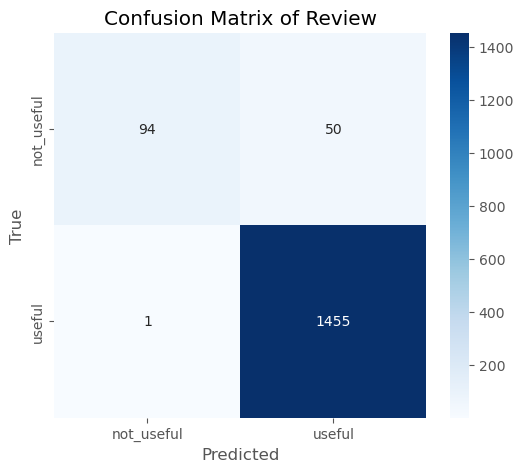

In [62]:
cm_train = confusion_matrix(y_train, y_pred_nb_train)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['not_useful','useful'], yticklabels=['not_useful','useful'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Review')
plt.show()

In [63]:
TN, FP, FN, TP = cm_train.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

precision_not_useful = TN / (TN + FN)
recall_not_useful = TN / (TN + FP)

print('accuracy :', accuracy)
print('precision :', precision)
print('recall :', recall)
print('f1_score :', f1_score)
print('')
print('precision not useful:', precision_not_useful)
print('recall not useful:', recall_not_useful)

accuracy : 0.968125
precision : 0.9667774086378738
recall : 0.9993131868131868
f1_score : 0.9827760891590679

precision not useful: 0.9894736842105263
recall not useful: 0.6527777777777778


### Predicting on test 

In [64]:
df_test

label                                               text  emoji_count  \
0        5  colour is very nice. the package was delivered...            1   
1        5  I only used it once and so far the quality is ...            0   
2        5  Very high quality products, very satisfied and...            0   
3        5  Received in good condition. Delivery was fast ...            0   
4        5  Items is very nice satisfied 👌.  But I'm a qui...            3   
..     ...                                                ...          ...   
395      5  Very good resistance esp the black one, cant w...            0   
396      4  Quality looks good and item received within a ...            0   
397      5  Receive in a good condition shipping is just w...            4   
398      5  Received in good condition. Bought the 15mm an...            0   
399      5  Looks good for me. Got it in flash deal. Good ...            0   

     word_count  char_count  \
0            18         118   
1            18          80   
2             9          66   
3            10          62   
4            24         132   
..          ...         ...   
395          20         111   
396           9          51   
397          28         158   
398          22         115   
399          21         105   

                                       cleaned_reviews  not_tried  \
0    colour nice . package deliver excellent condit...      False   
1                 use far quality good . love colour !      False   
2      high quality product , satisfy highly recommend      False   
3     receive good condition . delivery fast , thank !      False   
4    item nice satisfied 👌 . ' m quite disappointed...      False   
..                                                 ...        ...   
395  good resistance esp black one , can not wait t...      False   
396            quality look good receive within week .      False   
397  receive good condition shipping just state pos...      False   
398  receive good condition . buy 15 mm ' comfortab...      False   
399  look good . get flash deal . good to one . tha...      False   

                                    sentiment_polarity    neg    neu    pos  \
0    {'neg': 0.0, 'neu': 0.363, 'pos': 0.637, 'comp...  0.000  0.363  0.637   
1    {'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...  0.000  0.351  0.649   
2    {'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'comp...  0.000  0.408  0.592   
3    {'neg': 0.0, 'neu': 0.413, 'pos': 0.587, 'comp...  0.000  0.413  0.587   
4    {'neg': 0.317, 'neu': 0.421, 'pos': 0.262, 'co...  0.317  0.421  0.262   
..                                                 ...    ...    ...    ...   
395  {'neg': 0.0, 'neu': 0.711, 'pos': 0.289, 'comp...  0.000  0.711  0.289   
396  {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...  0.000  0.633  0.367   
397  {'neg': 0.0, 'neu': 0.658, 'pos': 0.342, 'comp...  0.000  0.658  0.342   
398  {'neg': 0.0, 'neu': 0.64, 'pos': 0.36, 'compou...  0.000  0.640  0.360   
399  {'neg': 0.0, 'neu': 0.464, 'pos': 0.536, 'comp...  0.000  0.464  0.536   

     compound verdict  
0      0.9059  useful  
1      0.8122  useful  
2      0.6997  useful  
3      0.6900  useful  
4     -0.2895  useful  
..        ...     ...  
395    0.7263  useful  
396    0.4404  useful  
397    0.8074  useful  
398    0.7351  useful  
399    0.8555  useful  

[400 rows x 13 columns]

In [65]:
vectorizer3 = vectorizer1.transform(df_test['cleaned_reviews'])
feature_names = vectorizer1.get_feature_names_out()
df_vectorizer3 = pd.DataFrame(vectorizer3.toarray(), columns=feature_names)
df_vectorizer3

10 10  10 day  10 mm  able to  again need  again thank  also come  \
0      0.0     0.0    0.0      0.0         0.0          0.0        0.0   
1      0.0     0.0    0.0      0.0         0.0          0.0        0.0   
2      0.0     0.0    0.0      0.0         0.0          0.0        0.0   
3      0.0     0.0    0.0      0.0         0.0          0.0        0.0   
4      0.0     0.0    0.0      0.0         0.0          0.0        0.0   
..     ...     ...    ...      ...         ...          ...        ...   
395    0.0     0.0    0.0      0.0         0.0          0.0        0.0   
396    0.0     0.0    0.0      0.0         0.0          0.0        0.0   
397    0.0     0.0    0.0      0.0         0.0          0.0        0.0   
398    0.0     0.0    0.0      0.0         0.0          0.0        0.0   
399    0.0     0.0    0.0      0.0         0.0          0.0        0.0   

     anti slip  arrive good  bag strap  ...  would not  would recommend  \
0          0.0          0.0        0.0  ...        0.0              0.0   
1          0.0          0.0        0.0  ...        0.0              0.0   
2          0.0          0.0        0.0  ...        0.0              0.0   
3          0.0          0.0        0.0  ...        0.0              0.0   
4          0.0          0.0        0.0  ...        0.0              0.0   
..         ...          ...        ...  ...        ...              ...   
395        0.0          0.0        0.0  ...        0.0              0.0   
396        0.0          0.0        0.0  ...        0.0              0.0   
397        0.0          0.0        0.0  ...        0.0              0.0   
398        0.0          0.0        0.0  ...        0.0              0.0   
399        0.0          0.0        0.0  ...        0.0              0.0   

     yesterday receive  yet hope  yet look  yet to  yet to try  yet to use  \
0                  0.0       0.0       0.0     0.0         0.0         0.0   
1                  0.0       0.0       0.0     0.0         0.0         0.0   
2                  0.0       0.0       0.0     0.0         0.0         0.0   
3                  0.0       0.0       0.0     0.0         0.0         0.0   
4                  0.0       0.0       0.0     0.0         0.0         0.0   
..                 ...       ...       ...     ...         ...         ...   
395                0.0       0.0       0.0     0.0         0.0         0.0   
396                0.0       0.0       0.0     0.0         0.0         0.0   
397                0.0       0.0       0.0     0.0         0.0         0.0   
398                0.0       0.0       0.0     0.0         0.0         0.0   
399                0.0       0.0       0.0     0.0         0.0         0.0   

     yet try  yoga mat  
0        0.0       0.0  
1        0.0       0.0  
2        0.0       0.0  
3        0.0       0.0  
4        0.0       0.0  
..       ...       ...  
395      0.0       0.0  
396      0.0       0.0  
397      0.0       0.0  
398      0.0       0.0  
399      0.0       0.0  

[400 rows x 509 columns]

In [66]:
df_test = pd.concat([df_test, df_vectorizer3], axis=1)
df_test

label                                               text  emoji_count  \
0        5  colour is very nice. the package was delivered...            1   
1        5  I only used it once and so far the quality is ...            0   
2        5  Very high quality products, very satisfied and...            0   
3        5  Received in good condition. Delivery was fast ...            0   
4        5  Items is very nice satisfied 👌.  But I'm a qui...            3   
..     ...                                                ...          ...   
395      5  Very good resistance esp the black one, cant w...            0   
396      4  Quality looks good and item received within a ...            0   
397      5  Receive in a good condition shipping is just w...            4   
398      5  Received in good condition. Bought the 15mm an...            0   
399      5  Looks good for me. Got it in flash deal. Good ...            0   

     word_count  char_count  \
0            18         118   
1            18          80   
2             9          66   
3            10          62   
4            24         132   
..          ...         ...   
395          20         111   
396           9          51   
397          28         158   
398          22         115   
399          21         105   

                                       cleaned_reviews  not_tried  \
0    colour nice . package deliver excellent condit...      False   
1                 use far quality good . love colour !      False   
2      high quality product , satisfy highly recommend      False   
3     receive good condition . delivery fast , thank !      False   
4    item nice satisfied 👌 . ' m quite disappointed...      False   
..                                                 ...        ...   
395  good resistance esp black one , can not wait t...      False   
396            quality look good receive within week .      False   
397  receive good condition shipping just state pos...      False   
398  receive good condition . buy 15 mm ' comfortab...      False   
399  look good . get flash deal . good to one . tha...      False   

                                    sentiment_polarity    neg    neu  ...  \
0    {'neg': 0.0, 'neu': 0.363, 'pos': 0.637, 'comp...  0.000  0.363  ...   
1    {'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...  0.000  0.351  ...   
2    {'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'comp...  0.000  0.408  ...   
3    {'neg': 0.0, 'neu': 0.413, 'pos': 0.587, 'comp...  0.000  0.413  ...   
4    {'neg': 0.317, 'neu': 0.421, 'pos': 0.262, 'co...  0.317  0.421  ...   
..                                                 ...    ...    ...  ...   
395  {'neg': 0.0, 'neu': 0.711, 'pos': 0.289, 'comp...  0.000  0.711  ...   
396  {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...  0.000  0.633  ...   
397  {'neg': 0.0, 'neu': 0.658, 'pos': 0.342, 'comp...  0.000  0.658  ...   
398  {'neg': 0.0, 'neu': 0.64, 'pos': 0.36, 'compou...  0.000  0.640  ...   
399  {'neg': 0.0, 'neu': 0.464, 'pos': 0.536, 'comp...  0.000  0.464  ...   

     would not  would recommend yesterday receive  yet hope  yet look  yet to  \
0          0.0              0.0               0.0       0.0       0.0     0.0   
1          0.0              0.0               0.0       0.0       0.0     0.0   
2          0.0              0.0               0.0       0.0       0.0     0.0   
3          0.0              0.0               0.0       0.0       0.0     0.0   
4          0.0              0.0               0.0       0.0       0.0     0.0   
..         ...              ...               ...       ...       ...     ...   
395        0.0              0.0               0.0       0.0       0.0     0.0   
396        0.0              0.0               0.0       0.0       0.0     0.0   
397        0.0              0.0               0.0       0.0       0.0     0.0   
398        0.0              0.0               0.0       0.0       0.0     0.0   
399        0.0              0.0               0.0 

In [67]:
df_test['rating_normalized'] = scaler.transform(df_test[['label']])
df_test

label                                               text  emoji_count  \
0        5  colour is very nice. the package was delivered...            1   
1        5  I only used it once and so far the quality is ...            0   
2        5  Very high quality products, very satisfied and...            0   
3        5  Received in good condition. Delivery was fast ...            0   
4        5  Items is very nice satisfied 👌.  But I'm a qui...            3   
..     ...                                                ...          ...   
395      5  Very good resistance esp the black one, cant w...            0   
396      4  Quality looks good and item received within a ...            0   
397      5  Receive in a good condition shipping is just w...            4   
398      5  Received in good condition. Bought the 15mm an...            0   
399      5  Looks good for me. Got it in flash deal. Good ...            0   

     word_count  char_count  \
0            18         118   
1            18          80   
2             9          66   
3            10          62   
4            24         132   
..          ...         ...   
395          20         111   
396           9          51   
397          28         158   
398          22         115   
399          21         105   

                                       cleaned_reviews  not_tried  \
0    colour nice . package deliver excellent condit...      False   
1                 use far quality good . love colour !      False   
2      high quality product , satisfy highly recommend      False   
3     receive good condition . delivery fast , thank !      False   
4    item nice satisfied 👌 . ' m quite disappointed...      False   
..                                                 ...        ...   
395  good resistance esp black one , can not wait t...      False   
396            quality look good receive within week .      False   
397  receive good condition shipping just state pos...      False   
398  receive good condition . buy 15 mm ' comfortab...      False   
399  look good . get flash deal . good to one . tha...      False   

                                    sentiment_polarity    neg    neu  ...  \
0    {'neg': 0.0, 'neu': 0.363, 'pos': 0.637, 'comp...  0.000  0.363  ...   
1    {'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...  0.000  0.351  ...   
2    {'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'comp...  0.000  0.408  ...   
3    {'neg': 0.0, 'neu': 0.413, 'pos': 0.587, 'comp...  0.000  0.413  ...   
4    {'neg': 0.317, 'neu': 0.421, 'pos': 0.262, 'co...  0.317  0.421  ...   
..                                                 ...    ...    ...  ...   
395  {'neg': 0.0, 'neu': 0.711, 'pos': 0.289, 'comp...  0.000  0.711  ...   
396  {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...  0.000  0.633  ...   
397  {'neg': 0.0, 'neu': 0.658, 'pos': 0.342, 'comp...  0.000  0.658  ...   
398  {'neg': 0.0, 'neu': 0.64, 'pos': 0.36, 'compou...  0.000  0.640  ...   
399  {'neg': 0.0, 'neu': 0.464, 'pos': 0.536, 'comp...  0.000  0.464  ...   

     would recommend  yesterday receive yet hope  yet look  yet to  \
0                0.0                0.0      0.0       0.0     0.0   
1                0.0                0.0      0.0       0.0     0.0   
2                0.0                0.0      0.0       0.0     0.0   
3                0.0                0.0      0.0       0.0     0.0   
4                0.0                0.0      0.0       0.0     0.0   
..               ...                ...      ...       ...     ...   
395              0.0                0.0      0.0       0.0     0.0   
396              0.0                0.0      0.0       0.0     0.0   
397              0.0                0.0      0.0       0.0     0.0   
398              0.0                0.0      0.0       0.0     0.0   
399              0.0                0.0      0.0       0.0     0.0   

     yet to try  yet to use  yet try  yoga mat  rating_normalized  
0           0.0         0.0     

In [68]:
# Predict on test dataset

X_test = df_test.drop(columns=['label','text','cleaned_reviews','not_tried','sentiment_polarity','word_count','char_count','neg','neu','pos','compound','verdict'])

y_test = df_test['verdict'].map({'not_useful':0, 'useful':1}).astype(float)
y_test

y_pred_nb_test = nb.predict(X_test.values)
y_pred_nb_prob = nb.predict_proba(X_test.values)[:, 1]

# Boundary condition
threshold = 0.7
y_pred_nb_test = (y_pred_nb_prob >= threshold).astype(int)

print("=== Naïve Bayes Classification Report ===")
print(classification_report(y_test, y_pred_nb_test, target_names=["not_useful","useful"]))

=== Naïve Bayes Classification Report ===
              precision    recall  f1-score   support

  not_useful       1.00      0.75      0.86        36
      useful       0.98      1.00      0.99       364

    accuracy                           0.98       400
   macro avg       0.99      0.88      0.92       400
weighted avg       0.98      0.98      0.98       400



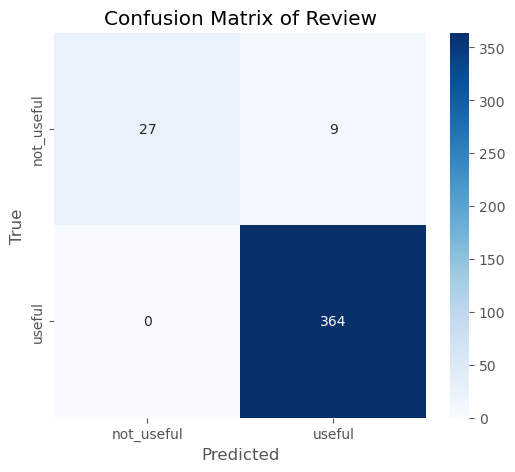

In [69]:
cm_test = confusion_matrix(y_test, y_pred_nb_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['not_useful','useful'], yticklabels=['not_useful','useful'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Review')
plt.show()

In [70]:
TN, FP, FN, TP = cm_test.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

precision_not_useful = TN / (TN + FN)
recall_not_useful = TN / (TN + FP)

print('accuracy :', accuracy)
print('precision :', precision)
print('recall :', recall)
print('f1_score :', f1_score)
print('')
print('precision not useful:', precision_not_useful)
print('recall not useful:', recall_not_useful)

accuracy : 0.9775
precision : 0.9758713136729222
recall : 1.0
f1_score : 0.9877883310719131

precision not useful: 1.0
recall not useful: 0.75


### SVM

In [71]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

In [72]:
svm = SGDClassifier(
    loss="hinge",
    penalty="l2",
    class_weight="balanced",
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

# svm = SVC(kernel='linear', probability=True, class_weight='balanced')

svm.fit(X_train.values, y_train.values)
y_pred_svm_train = svm.predict(X_train.values)
print("\n=== Linear SVM (test) ===")
print(classification_report(y_train, y_pred_svm_train, target_names=["not_useful","useful"]))


=== Linear SVM (test) ===
              precision    recall  f1-score   support

  not_useful       0.85      0.92      0.88       144
      useful       0.99      0.98      0.99      1456

    accuracy                           0.98      1600
   macro avg       0.92      0.95      0.93      1600
weighted avg       0.98      0.98      0.98      1600



In [73]:
# Predict on test dataset

y_pred_svm_test = svm.predict(X_test.values)
print("\n=== Linear SVM (test) ===")
print(classification_report(y_test, y_pred_svm_test, target_names=["not_useful","useful"]))


=== Linear SVM (test) ===
              precision    recall  f1-score   support

  not_useful       0.87      0.75      0.81        36
      useful       0.98      0.99      0.98       364

    accuracy                           0.97       400
   macro avg       0.92      0.87      0.89       400
weighted avg       0.97      0.97      0.97       400



## **Naive Bayes produces a better model to accurately predict not_useful reviews. Roll out further testing on bigger sample size.**

# Train data on sample (initial 2000 reviews)

### Vectorize reviews

In [74]:
vectorizer1 = TfidfVectorizer(ngram_range=(2,3), min_df=5, max_features=5000)
vectorizer2 = vectorizer1.fit_transform(sample['cleaned_reviews'])
feature_names = vectorizer1.get_feature_names_out()
sample_vectorizer2 = pd.DataFrame(vectorizer2.toarray(), columns=feature_names)
sample_vectorizer2.reset_index(drop=True)

10 10  10 day  10 mm  able to  adjustable strap  again future  \
0       0.0     0.0    0.0      0.0               0.0           0.0   
1       0.0     0.0    0.0      0.0               0.0           0.0   
2       0.0     0.0    0.0      0.0               0.0           0.0   
3       0.0     0.0    0.0      0.0               0.0           0.0   
4       0.0     0.0    0.0      0.0               0.0           0.0   
...     ...     ...    ...      ...               ...           ...   
1995    0.0     0.0    0.0      0.0               0.0           0.0   
1996    0.0     0.0    0.0      0.0               0.0           0.0   
1997    0.0     0.0    0.0      0.0               0.0           0.0   
1998    0.0     0.0    0.0      0.0               0.0           0.0   
1999    0.0     0.0    0.0      0.0               0.0           0.0   

      again need  again thank  also come  anti slip  ...  would recommend  \
0            0.0          0.0        0.0        0.0  ...              0.0   
1            0.0          0.0        0.0        0.0  ...              0.0   
2            0.0          0.0        0.0        0.0  ...              0.0   
3            0.0          0.0        0.0        0.0  ...              0.0   
4            0.0          0.0        0.0        0.0  ...              0.0   
...          ...          ...        ...        ...  ...              ...   
1995         0.0          0.0        0.0        0.0  ...              0.0   
1996         0.0          0.0        0.0        0.0  ...              0.0   
1997         0.0          0.0        0.0        0.0  ...              0.0   
1998         0.0          0.0        0.0        0.0  ...              0.0   
1999         0.0          0.0        0.0        0.0  ...              0.0   

      wrong size  yesterday receive  yet hope  yet look  yet to  yet to try  \
0            0.0                0.0       0.0       0.0     0.0         0.0   
1            0.0                0.0       0.0       0.0     0.0         0.0   
2            0.0                0.0       0.0       0.0     0.0         0.0   
3            0.0                0.0       0.0       0.0     0.0         0.0   
4            0.0                0.0       0.0       0.0     0.0         0.0   
...          ...                ...       ...       ...     ...         ...   
1995         0.0                0.0       0.0       0.0     0.0         0.0   
1996         0.0                0.0       0.0       0.0     0.0         0.0   
1997         0.0                0.0       0.0       0.0     0.0         0.0   
1998         0.0                0.0       0.0       0.0     0.0         0.0   
1999         0.0                0.0       0.0       0.0     0.0         0.0   

      yet to use  yet try  yoga mat  
0            0.0      0.0       0.0  
1            0.0      0.0       0.0  
2            0.0      0.0       0.0  
3            0.0      0.0       0.0  
4            0.0      0.0       0.0  
...          ...      ...       ...  
1995         0.0      0.0       0.0  
1996         0.0      0.0       0.0  
1997         0.0      0.0       0.0  
1998         0.0      0.0       0.0  
1999         0.0      0.0       0.0  

[2000 rows x 662 columns]

In [75]:
sample = pd.concat([sample, sample_vectorizer2], axis=1)
sample

label                                               text  emoji_count  \
0         5  Looks ok. Not like so durable. Will hv to use ...            0   
1         5  Tried, the current can be very powerful depend...            0   
2         5  Item received after a week. Looks smaller than...            0   
3         5  Thanks!!! Works as describe no complaints. Not...            0   
4         5  Fast delivery considering it’s from overseas a...            0   
...     ...                                                ...          ...   
1995      5  Works really well and thanks for all the free ...            0   
1996      5  Item received ...................... n  . .......            0   
1997      5  Received in good condition and everything work...            0   
1998      5  Good deal but not happy that your courier mark...            0   
1999      3  Fast delivery but with a few cracks here and t...            0   

      word_count  char_count  \
0             18          87   
1             32         168   
2             13          75   
3             15         101   
4             16          97   
...          ...         ...   
1995          21          98   
1996           6          57   
1997          12          73   
1998          17          97   
1999          10          51   

                                        cleaned_reviews  not_tried  \
0     look ok . not like durable . will hv to use to...      False   
1     try , current can powerful depend setting , no...      False   
2     receive week . look small expect , can ' wait ...       True   
3     thanks ! ! ! work describe no complaint . not ...      False   
4     fast delivery consider ' overseas try . not su...       True   
...                                                 ...        ...   
1995  work really well thank free gift : ) hope to p...      False   
1996  receive ...................... n . ..............      False   
1997  receive good condition everything work per sta...      False   
1998  good deal not happy courier marked deliver few...      False   
1999                            fast delivery few crack      False   

                                     sentiment_polarity    neg    neu  ...  \
0     {'neg': 0.119, 'neu': 0.508, 'pos': 0.373, 'co...  0.119  0.508  ...   
1     {'neg': 0.094, 'neu': 0.714, 'pos': 0.192, 'co...  0.094  0.714  ...   
2     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000  1.000  ...   
3     {'neg': 0.232, 'neu': 0.422, 'pos': 0.346, 'co...  0.232  0.422  ...   
4     {'neg': 0.197, 'neu': 0.803, 'pos': 0.0, 'comp...  0.197  0.803  ...   
...                                                 ...    ...    ...  ...   
1995  {'neg': 0.0, 'neu': 0.283, 'pos': 0.717, 'comp...  0.000  0.283  ...   
1996  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000  1.000  ...   
1997  {'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...  0.000  0.423  ...   
1998  {'neg': 0.201, 'neu': 0.604, 'pos': 0.195, 'co...  0.201  0.604  ...   
1999  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000  1.000  ...   

      would recommend  wrong size yesterday receive  yet hope  yet look  \
0                 0.0         0.0               0.0       0.0       0.0   
1                 0.0         0.0               0.0       0.0       0.0   
2                 0.0         0.0               0.0       0.0       0.0   
3                 0.0         0.0               0.0       0.0       0.0   
4                 0.0         0.0               0.0       0.0       0.0   
...               ...         ...               ...       ...       ...   
1995              0.0         0.0               0.0       0.0       0.0   
1996              0.0         0.0               0.0       0.0       0.0   
1997              0.0         0.0               0.0       0.0       0.0   
1998              0.0         0.0               0.0       0.0       0.0   
1999              0.0         0.0               0.0       0.0       0

### Scale rating to match scale of vectorized reviews

In [76]:
scaler = MinMaxScaler()
sample['rating_normalized'] = scaler.fit_transform(sample[['label']])
sample

label                                               text  emoji_count  \
0         5  Looks ok. Not like so durable. Will hv to use ...            0   
1         5  Tried, the current can be very powerful depend...            0   
2         5  Item received after a week. Looks smaller than...            0   
3         5  Thanks!!! Works as describe no complaints. Not...            0   
4         5  Fast delivery considering it’s from overseas a...            0   
...     ...                                                ...          ...   
1995      5  Works really well and thanks for all the free ...            0   
1996      5  Item received ...................... n  . .......            0   
1997      5  Received in good condition and everything work...            0   
1998      5  Good deal but not happy that your courier mark...            0   
1999      3  Fast delivery but with a few cracks here and t...            0   

      word_count  char_count  \
0             18          87   
1             32         168   
2             13          75   
3             15         101   
4             16          97   
...          ...         ...   
1995          21          98   
1996           6          57   
1997          12          73   
1998          17          97   
1999          10          51   

                                        cleaned_reviews  not_tried  \
0     look ok . not like durable . will hv to use to...      False   
1     try , current can powerful depend setting , no...      False   
2     receive week . look small expect , can ' wait ...       True   
3     thanks ! ! ! work describe no complaint . not ...      False   
4     fast delivery consider ' overseas try . not su...       True   
...                                                 ...        ...   
1995  work really well thank free gift : ) hope to p...      False   
1996  receive ...................... n . ..............      False   
1997  receive good condition everything work per sta...      False   
1998  good deal not happy courier marked deliver few...      False   
1999                            fast delivery few crack      False   

                                     sentiment_polarity    neg    neu  ...  \
0     {'neg': 0.119, 'neu': 0.508, 'pos': 0.373, 'co...  0.119  0.508  ...   
1     {'neg': 0.094, 'neu': 0.714, 'pos': 0.192, 'co...  0.094  0.714  ...   
2     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000  1.000  ...   
3     {'neg': 0.232, 'neu': 0.422, 'pos': 0.346, 'co...  0.232  0.422  ...   
4     {'neg': 0.197, 'neu': 0.803, 'pos': 0.0, 'comp...  0.197  0.803  ...   
...                                                 ...    ...    ...  ...   
1995  {'neg': 0.0, 'neu': 0.283, 'pos': 0.717, 'comp...  0.000  0.283  ...   
1996  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000  1.000  ...   
1997  {'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...  0.000  0.423  ...   
1998  {'neg': 0.201, 'neu': 0.604, 'pos': 0.195, 'co...  0.201  0.604  ...   
1999  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000  1.000  ...   

      wrong size  yesterday receive yet hope  yet look  yet to  yet to try  \
0            0.0                0.0      0.0       0.0     0.0         0.0   
1            0.0                0.0      0.0       0.0     0.0         0.0   
2            0.0                0.0      0.0       0.0     0.0         0.0   
3            0.0                0.0      0.0       0.0     0.0         0.0   
4            0.0                0.0      0.0       0.0     0.0         0.0   
...          ...                ...      ...       ...     ...         ...   
1995         0.0                0.0      0.0       0.0     0.0         0.0   
1996         0.0                0.0      0.0       0.0     0.0         0.0   
1997         0.0                0.0      0.0       0.0     0.0         0.0   
1998         0.0                0.0      0.0       0.0     0.0         0.0   
1999         0.0                0.0 

In [77]:
X_sample = sample.drop(columns=['label','text','cleaned_reviews','not_tried','sentiment_polarity','emoji_count','word_count','char_count','neg','neu','pos','compound','verdict'])
X_sample

10 10  10 day  10 mm  able to  adjustable strap  again future  \
0       0.0     0.0    0.0      0.0               0.0           0.0   
1       0.0     0.0    0.0      0.0               0.0           0.0   
2       0.0     0.0    0.0      0.0               0.0           0.0   
3       0.0     0.0    0.0      0.0               0.0           0.0   
4       0.0     0.0    0.0      0.0               0.0           0.0   
...     ...     ...    ...      ...               ...           ...   
1995    0.0     0.0    0.0      0.0               0.0           0.0   
1996    0.0     0.0    0.0      0.0               0.0           0.0   
1997    0.0     0.0    0.0      0.0               0.0           0.0   
1998    0.0     0.0    0.0      0.0               0.0           0.0   
1999    0.0     0.0    0.0      0.0               0.0           0.0   

      again need  again thank  also come  anti slip  ...  wrong size  \
0            0.0          0.0        0.0        0.0  ...         0.0   
1            0.0          0.0        0.0        0.0  ...         0.0   
2            0.0          0.0        0.0        0.0  ...         0.0   
3            0.0          0.0        0.0        0.0  ...         0.0   
4            0.0          0.0        0.0        0.0  ...         0.0   
...          ...          ...        ...        ...  ...         ...   
1995         0.0          0.0        0.0        0.0  ...         0.0   
1996         0.0          0.0        0.0        0.0  ...         0.0   
1997         0.0          0.0        0.0        0.0  ...         0.0   
1998         0.0          0.0        0.0        0.0  ...         0.0   
1999         0.0          0.0        0.0        0.0  ...         0.0   

      yesterday receive  yet hope  yet look  yet to  yet to try  yet to use  \
0                   0.0       0.0       0.0     0.0         0.0         0.0   
1                   0.0       0.0       0.0     0.0         0.0         0.0   
2                   0.0       0.0       0.0     0.0         0.0         0.0   
3                   0.0       0.0       0.0     0.0         0.0         0.0   
4                   0.0       0.0       0.0     0.0         0.0         0.0   
...                 ...       ...       ...     ...         ...         ...   
1995                0.0       0.0       0.0     0.0         0.0         0.0   
1996                0.0       0.0       0.0     0.0         0.0         0.0   
1997                0.0       0.0       0.0     0.0         0.0         0.0   
1998                0.0       0.0       0.0     0.0         0.0         0.0   
1999                0.0       0.0       0.0     0.0         0.0         0.0   

      yet try  yoga mat  rating_normalized  
0         0.0       0.0                1.0  
1         0.0       0.0                1.0  
2         0.0       0.0                1.0  
3         0.0       0.0                1.0  
4         0.0       0.0                1.0  
...       ...       ...                ...  
1995      0.0       0.0                1.0  
1996      0.0       0.0                1.0  
1997      0.0       0.0                1.0  
1998      0.0       0.0                1.0  
1999      0.0       0.0                0.5  

[2000 rows x 663 columns]

In [78]:
y_sample = sample['verdict'].map({'not_useful':0, 'useful':1}).astype(float)
y_sample

0       1.0
1       1.0
2       0.0
3       1.0
4       0.0
       ... 
1995    1.0
1996    0.0
1997    1.0
1998    0.0
1999    0.0
Name: verdict, Length: 2000, dtype: float64

In [79]:
nb_sample = MultinomialNB(alpha=1.0)
nb_sample.fit(X_sample.values, y_sample.values)

MultinomialNB()

# Predict on 10k reviews

In [80]:
ten_k = reviews[2000:12000]
ten_k = ten_k.reset_index(drop=True)

## **Clean 10k Reviews**

#### Tokenize, remove numerals, punctuations and stopwords, lemmatize

In [81]:
ten_k.loc[:,'cleaned_reviews'] = ten_k['text'].apply(preprocess_text)
ten_k

label                                               text  emoji_count  \
0         5  Not bad for its price. Deliver within 2 days. ...            0   
1         5  Delivered within 1 week. Item true to picture ...            0   
2         5   Fast delivery, looks good.  Thanks to the del...            0   
3         5  order arrived within a week well packaged. jus...            0   
4         5  Material is good. Certainly feels like the sta...            0   
...     ...                                                ...          ...   
9995      5  This was taken after a 20 Km trip. Wonderful. ...            0   
9996      5  Very very good service.  Condition of bike is ...            0   
9997      5  Very fast delivery, received item within 15 ho...            0   
9998      5  Order received in excellent condition. Ordered...            0   
9999      5  Very fast deliver, and looks good too! Cant wa...            0   

      word_count  char_count  \
0             11          61   
1             16          91   
2             15          86   
3             29         152   
4             12          79   
...          ...         ...   
9995          49         283   
9996           9          52   
9997          10          65   
9998          22         127   
9999          12          59   

                                        cleaned_reviews  
0     not bad price . deliver within 2 day . will re...  
1     deliver within 1 week . true to picture shop ....  
2     fast delivery , look good . thank to delivery ...  
3     order arrive within week well package . just b...  
4     material good . certainly feel like state weig...  
...                                                 ...  
9995  take 20 km trip . wonderful . may squeaky soun...  
9996                good service . condition bike super  
9997  fast delivery , receive within 15 hour purchase .  
9998  order receive excellent condition . order 1 pm...  
9999  fast deliver , look good ! can not wait to try...  

[10000 rows x 6 columns]

### Vectorize 10k reviews

In [82]:
vectorizer4 = vectorizer1.transform(ten_k['cleaned_reviews'])
feature_names = vectorizer1.get_feature_names_out()
ten_k_vectorizer = pd.DataFrame(vectorizer4.toarray(), columns=feature_names)
ten_k_vectorizer.reset_index(drop=True)

10 10  10 day  10 mm  able to  adjustable strap  again future  \
0       0.0     0.0    0.0      0.0               0.0           0.0   
1       0.0     0.0    0.0      0.0               0.0           0.0   
2       0.0     0.0    0.0      0.0               0.0           0.0   
3       0.0     0.0    0.0      0.0               0.0           0.0   
4       0.0     0.0    0.0      0.0               0.0           0.0   
...     ...     ...    ...      ...               ...           ...   
9995    0.0     0.0    0.0      0.0               0.0           0.0   
9996    0.0     0.0    0.0      0.0               0.0           0.0   
9997    0.0     0.0    0.0      0.0               0.0           0.0   
9998    0.0     0.0    0.0      0.0               0.0           0.0   
9999    0.0     0.0    0.0      0.0               0.0           0.0   

      again need  again thank  also come  anti slip  ...  would recommend  \
0            0.0          0.0        0.0        0.0  ...              0.0   
1            0.0          0.0        0.0        0.0  ...              0.0   
2            0.0          0.0        0.0        0.0  ...              0.0   
3            0.0          0.0        0.0        0.0  ...              0.0   
4            0.0          0.0        0.0        0.0  ...              0.0   
...          ...          ...        ...        ...  ...              ...   
9995         0.0          0.0        0.0        0.0  ...              0.0   
9996         0.0          0.0        0.0        0.0  ...              0.0   
9997         0.0          0.0        0.0        0.0  ...              0.0   
9998         0.0          0.0        0.0        0.0  ...              0.0   
9999         0.0          0.0        0.0        0.0  ...              0.0   

      wrong size  yesterday receive  yet hope  yet look  yet to  yet to try  \
0            0.0                0.0       0.0       0.0     0.0         0.0   
1            0.0                0.0       0.0       0.0     0.0         0.0   
2            0.0                0.0       0.0       0.0     0.0         0.0   
3            0.0                0.0       0.0       0.0     0.0         0.0   
4            0.0                0.0       0.0       0.0     0.0         0.0   
...          ...                ...       ...       ...     ...         ...   
9995         0.0                0.0       0.0       0.0     0.0         0.0   
9996         0.0                0.0       0.0       0.0     0.0         0.0   
9997         0.0                0.0       0.0       0.0     0.0         0.0   
9998         0.0                0.0       0.0       0.0     0.0         0.0   
9999         0.0                0.0       0.0       0.0     0.0         0.0   

      yet to use  yet try  yoga mat  
0            0.0      0.0       0.0  
1            0.0      0.0       0.0  
2            0.0      0.0       0.0  
3            0.0      0.0       0.0  
4            0.0      0.0       0.0  
...          ...      ...       ...  
9995         0.0      0.0       0.0  
9996         0.0      0.0       0.0  
9997         0.0      0.0       0.0  
9998         0.0      0.0       0.0  
9999         0.0      0.0       0.0  

[10000 rows x 662 columns]

In [83]:
ten_k = pd.concat([ten_k, ten_k_vectorizer], axis=1)
ten_k

label                                               text  emoji_count  \
0         5  Not bad for its price. Deliver within 2 days. ...            0   
1         5  Delivered within 1 week. Item true to picture ...            0   
2         5   Fast delivery, looks good.  Thanks to the del...            0   
3         5  order arrived within a week well packaged. jus...            0   
4         5  Material is good. Certainly feels like the sta...            0   
...     ...                                                ...          ...   
9995      5  This was taken after a 20 Km trip. Wonderful. ...            0   
9996      5  Very very good service.  Condition of bike is ...            0   
9997      5  Very fast delivery, received item within 15 ho...            0   
9998      5  Order received in excellent condition. Ordered...            0   
9999      5  Very fast deliver, and looks good too! Cant wa...            0   

      word_count  char_count  \
0             11          61   
1             16          91   
2             15          86   
3             29         152   
4             12          79   
...          ...         ...   
9995          49         283   
9996           9          52   
9997          10          65   
9998          22         127   
9999          12          59   

                                        cleaned_reviews  10 10  10 day  10 mm  \
0     not bad price . deliver within 2 day . will re...    0.0     0.0    0.0   
1     deliver within 1 week . true to picture shop ....    0.0     0.0    0.0   
2     fast delivery , look good . thank to delivery ...    0.0     0.0    0.0   
3     order arrive within week well package . just b...    0.0     0.0    0.0   
4     material good . certainly feel like state weig...    0.0     0.0    0.0   
...                                                 ...    ...     ...    ...   
9995  take 20 km trip . wonderful . may squeaky soun...    0.0     0.0    0.0   
9996                good service . condition bike super    0.0     0.0    0.0   
9997  fast delivery , receive within 15 hour purchase .    0.0     0.0    0.0   
9998  order receive excellent condition . order 1 pm...    0.0     0.0    0.0   
9999  fast deliver , look good ! can not wait to try...    0.0     0.0    0.0   

      able to  ...  would recommend  wrong size  yesterday receive  yet hope  \
0         0.0  ...              0.0         0.0                0.0       0.0   
1         0.0  ...              0.0         0.0                0.0       0.0   
2         0.0  ...              0.0         0.0                0.0       0.0   
3         0.0  ...              0.0         0.0                0.0       0.0   
4         0.0  ...              0.0         0.0                0.0       0.0   
...       ...  ...              ...         ...                ...       ...   
9995      0.0  ...              0.0         0.0                0.0       0.0   
9996      0.0  ...              0.0         0.0                0.0       0.0   
9997      0.0  ...              0.0         0.0                0.0       0.0   
9998      0.0  ...              0.0         0.0                0.0       0.0   
9999      0.0  ...              0.0         0.0                0.0       0.0   

      yet look  yet to  yet to try  yet to use  yet try  yoga mat  
0          0.0     0.0         0.0         0.0      0.0       0.0  
1          0.0     0.0         0.0         0.0      0.0       0.0  
2          0.0     0.0         0.0         0.0      0.0       0.0  
3          0.0     0.0         0.0         0.0      0.0       0.0  
4          0.0     0.0         0.0         0.0      0.0       0.0  
...        ...     ...         ...         ...      ...       ...  
9995       0.0     0.0         0.0         0.0      0.0       0.0  
9996       0.0     0.0         0.0         0.0      0.0       0.0  
9997       0.0     0.0         0.0         0.0      0.0       0.0  
9998       0.0     0.0         0.0         0.0      0.0   

### Scale rating to match scale of vectorized reviews

In [84]:
ten_k['rating_normalized'] = scaler.transform(ten_k[['label']])
ten_k

label                                               text  emoji_count  \
0         5  Not bad for its price. Deliver within 2 days. ...            0   
1         5  Delivered within 1 week. Item true to picture ...            0   
2         5   Fast delivery, looks good.  Thanks to the del...            0   
3         5  order arrived within a week well packaged. jus...            0   
4         5  Material is good. Certainly feels like the sta...            0   
...     ...                                                ...          ...   
9995      5  This was taken after a 20 Km trip. Wonderful. ...            0   
9996      5  Very very good service.  Condition of bike is ...            0   
9997      5  Very fast delivery, received item within 15 ho...            0   
9998      5  Order received in excellent condition. Ordered...            0   
9999      5  Very fast deliver, and looks good too! Cant wa...            0   

      word_count  char_count  \
0             11          61   
1             16          91   
2             15          86   
3             29         152   
4             12          79   
...          ...         ...   
9995          49         283   
9996           9          52   
9997          10          65   
9998          22         127   
9999          12          59   

                                        cleaned_reviews  10 10  10 day  10 mm  \
0     not bad price . deliver within 2 day . will re...    0.0     0.0    0.0   
1     deliver within 1 week . true to picture shop ....    0.0     0.0    0.0   
2     fast delivery , look good . thank to delivery ...    0.0     0.0    0.0   
3     order arrive within week well package . just b...    0.0     0.0    0.0   
4     material good . certainly feel like state weig...    0.0     0.0    0.0   
...                                                 ...    ...     ...    ...   
9995  take 20 km trip . wonderful . may squeaky soun...    0.0     0.0    0.0   
9996                good service . condition bike super    0.0     0.0    0.0   
9997  fast delivery , receive within 15 hour purchase .    0.0     0.0    0.0   
9998  order receive excellent condition . order 1 pm...    0.0     0.0    0.0   
9999  fast deliver , look good ! can not wait to try...    0.0     0.0    0.0   

      able to  ...  wrong size  yesterday receive  yet hope  yet look  yet to  \
0         0.0  ...         0.0                0.0       0.0       0.0     0.0   
1         0.0  ...         0.0                0.0       0.0       0.0     0.0   
2         0.0  ...         0.0                0.0       0.0       0.0     0.0   
3         0.0  ...         0.0                0.0       0.0       0.0     0.0   
4         0.0  ...         0.0                0.0       0.0       0.0     0.0   
...       ...  ...         ...                ...       ...       ...     ...   
9995      0.0  ...         0.0                0.0       0.0       0.0     0.0   
9996      0.0  ...         0.0                0.0       0.0       0.0     0.0   
9997      0.0  ...         0.0                0.0       0.0       0.0     0.0   
9998      0.0  ...         0.0                0.0       0.0       0.0     0.0   
9999      0.0  ...         0.0                0.0       0.0       0.0     0.0   

      yet to try  yet to use  yet try  yoga mat  rating_normalized  
0            0.0         0.0      0.0       0.0                1.0  
1            0.0         0.0      0.0       0.0                1.0  
2            0.0         0.0      0.0       0.0                1.0  
3            0.0         0.0      0.0       0.0                1.0  
4            0.0         0.0      0.0       0.0                1.0  
...          ...         ...      ...       ...                ...  
9995         0.0         0.0      0.0       0.0                1.0  
9996         0.0         0.0      0.0       0.0                1.0  
9997         0.0         0.0      0.0       0.0                1.0  
9998         0.0         0.0      0.

In [85]:
X_ten_k = ten_k.drop(columns=['label','text','cleaned_reviews','emoji_count','word_count','char_count'])
X_ten_k

10 10  10 day  10 mm  able to  adjustable strap  again future  \
0       0.0     0.0    0.0      0.0               0.0           0.0   
1       0.0     0.0    0.0      0.0               0.0           0.0   
2       0.0     0.0    0.0      0.0               0.0           0.0   
3       0.0     0.0    0.0      0.0               0.0           0.0   
4       0.0     0.0    0.0      0.0               0.0           0.0   
...     ...     ...    ...      ...               ...           ...   
9995    0.0     0.0    0.0      0.0               0.0           0.0   
9996    0.0     0.0    0.0      0.0               0.0           0.0   
9997    0.0     0.0    0.0      0.0               0.0           0.0   
9998    0.0     0.0    0.0      0.0               0.0           0.0   
9999    0.0     0.0    0.0      0.0               0.0           0.0   

      again need  again thank  also come  anti slip  ...  wrong size  \
0            0.0          0.0        0.0        0.0  ...         0.0   
1            0.0          0.0        0.0        0.0  ...         0.0   
2            0.0          0.0        0.0        0.0  ...         0.0   
3            0.0          0.0        0.0        0.0  ...         0.0   
4            0.0          0.0        0.0        0.0  ...         0.0   
...          ...          ...        ...        ...  ...         ...   
9995         0.0          0.0        0.0        0.0  ...         0.0   
9996         0.0          0.0        0.0        0.0  ...         0.0   
9997         0.0          0.0        0.0        0.0  ...         0.0   
9998         0.0          0.0        0.0        0.0  ...         0.0   
9999         0.0          0.0        0.0        0.0  ...         0.0   

      yesterday receive  yet hope  yet look  yet to  yet to try  yet to use  \
0                   0.0       0.0       0.0     0.0         0.0         0.0   
1                   0.0       0.0       0.0     0.0         0.0         0.0   
2                   0.0       0.0       0.0     0.0         0.0         0.0   
3                   0.0       0.0       0.0     0.0         0.0         0.0   
4                   0.0       0.0       0.0     0.0         0.0         0.0   
...                 ...       ...       ...     ...         ...         ...   
9995                0.0       0.0       0.0     0.0         0.0         0.0   
9996                0.0       0.0       0.0     0.0         0.0         0.0   
9997                0.0       0.0       0.0     0.0         0.0         0.0   
9998                0.0       0.0       0.0     0.0         0.0         0.0   
9999                0.0       0.0       0.0     0.0         0.0         0.0   

      yet try  yoga mat  rating_normalized  
0         0.0       0.0                1.0  
1         0.0       0.0                1.0  
2         0.0       0.0                1.0  
3         0.0       0.0                1.0  
4         0.0       0.0                1.0  
...       ...       ...                ...  
9995      0.0       0.0                1.0  
9996      0.0       0.0                1.0  
9997      0.0       0.0                1.0  
9998      0.0       0.0                1.0  
9999      0.0       0.0                1.0  

[10000 rows x 663 columns]

## **Run model on 10k reviews**

In [86]:
#Run NB model from trained model from the previous 2000 reviews (nb_sample)
y_pred_nb_prob = nb_sample.predict_proba(X_ten_k.values)[:, 1]

# Boundary condition
threshold = 0.7
y_pred_nb_ten_k = (y_pred_nb_prob >= threshold).astype(int)

ten_k['y_pred_nb_ten_k'] = nb_sample.predict(X_ten_k.values)

In [87]:
# Drop unwanted columns
cols_to_drop = set(X_sample.columns)
ten_k = ten_k.drop(columns=[c for c in ten_k.columns if c in cols_to_drop])

In [88]:
ten_k.to_csv('ten_k.csv')

# Text Review Analysis on 10k reviews

In [89]:
ten_k.loc[:,'not_tried'] = ten_k['cleaned_reviews'].apply(label_not_tried)
ten_k

label                                               text  emoji_count  \
0         5  Not bad for its price. Deliver within 2 days. ...            0   
1         5  Delivered within 1 week. Item true to picture ...            0   
2         5   Fast delivery, looks good.  Thanks to the del...            0   
3         5  order arrived within a week well packaged. jus...            0   
4         5  Material is good. Certainly feels like the sta...            0   
...     ...                                                ...          ...   
9995      5  This was taken after a 20 Km trip. Wonderful. ...            0   
9996      5  Very very good service.  Condition of bike is ...            0   
9997      5  Very fast delivery, received item within 15 ho...            0   
9998      5  Order received in excellent condition. Ordered...            0   
9999      5  Very fast deliver, and looks good too! Cant wa...            0   

      word_count  char_count  \
0             11          61   
1             16          91   
2             15          86   
3             29         152   
4             12          79   
...          ...         ...   
9995          49         283   
9996           9          52   
9997          10          65   
9998          22         127   
9999          12          59   

                                        cleaned_reviews  y_pred_nb_ten_k  \
0     not bad price . deliver within 2 day . will re...              1.0   
1     deliver within 1 week . true to picture shop ....              1.0   
2     fast delivery , look good . thank to delivery ...              1.0   
3     order arrive within week well package . just b...              1.0   
4     material good . certainly feel like state weig...              1.0   
...                                                 ...              ...   
9995  take 20 km trip . wonderful . may squeaky soun...              1.0   
9996                good service . condition bike super              1.0   
9997  fast delivery , receive within 15 hour purchase .              1.0   
9998  order receive excellent condition . order 1 pm...              1.0   
9999  fast deliver , look good ! can not wait to try...              0.0   

      not_tried  
0         False  
1         False  
2         False  
3         False  
4         False  
...         ...  
9995      False  
9996      False  
9997      False  
9998      False  
9999       True  

[10000 rows x 8 columns]

In [90]:
ten_k['not_tried'].value_counts()
# 6% of reviews indicated that product is not tried before reviewing

not_tried
False    9423
True      577
Name: count, dtype: int64

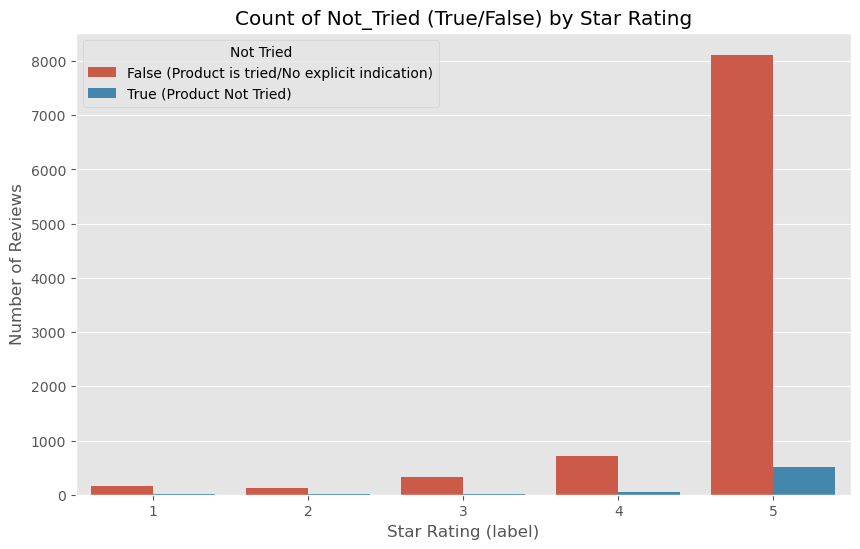

In [91]:
plt.figure(figsize=(10, 6))
sns.countplot(data=ten_k, x='label', hue='not_tried')
plt.title('Count of Not_Tried (True/False) by Star Rating')
plt.xlabel('Star Rating (label)')
plt.ylabel('Number of Reviews')
plt.legend(title='Not Tried', loc='upper left', labels=['False (Product is tried/No explicit indication)', 'True (Product Not Tried)'])
plt.show()

## Word Clouds

In [94]:
from wordcloud import WordCloud

In [95]:
fivestar_reviews = ten_k[ten_k['label'] == 5]
fourstar_reviews = ten_k[ten_k['label'] == 4]
threestar_reviews = ten_k[ten_k['label'] == 3]
twostar_reviews = ten_k[ten_k['label'] == 2]
onestar_reviews = ten_k[ten_k['label'] == 1]

### All tokens

(-0.5, 799.5, 399.5, -0.5)

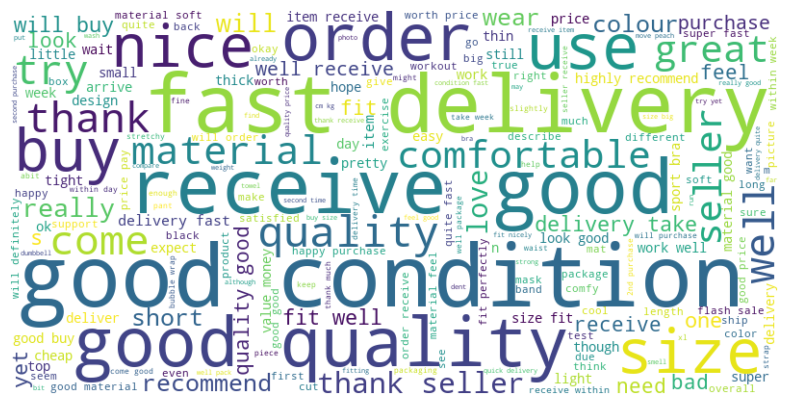

In [121]:
all_tokens = [word
              for review_text in ten_k['cleaned_reviews']
              for word in review_text.split()]

text_for_wc = " ".join(all_tokens)

wc = WordCloud(
    width=800, 
    height=400, 
    background_color="white").generate(text_for_wc)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

### Wordcloud for ratings

#### 5-star

687302 total words in 8625 5-star reviews


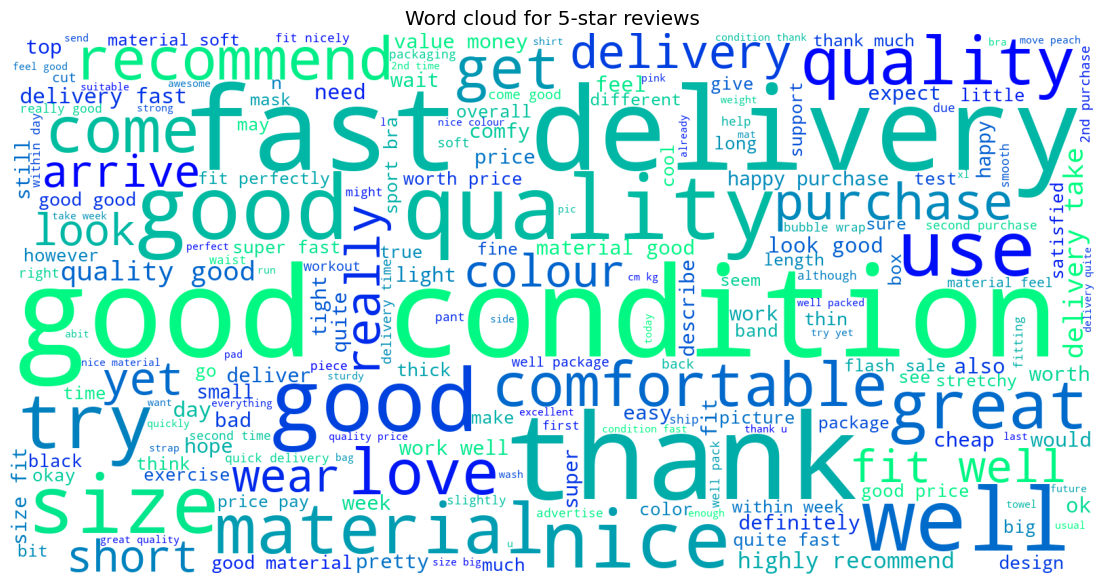

In [112]:
all_fivestar_reviews = " ".join(review for review in fivestar_reviews['cleaned_reviews'])

pos_stopwords = set(stop_words)
pos_stopwords.update({
    'seller',
    'item', 'product', 'items',
    'received', 'receive',
    'ordered', 'Ordered', 'buy','order',
    'one',
    'though', 'even', 'like'
    
})

print('{0} total words in {1} 5-star reviews'.format(len(all_fivestar_reviews), len(fivestar_reviews)))

fivestar_word_cloud = WordCloud(width=1600,
                                height=800,
                                background_color='white',
                                colormap='winter',
                                stopwords=pos_stopwords).generate(all_fivestar_reviews)

fig, axes = plt.subplots(figsize=(14, 8))
axes.imshow(fivestar_word_cloud)
axes.set_title('Word cloud for 5-star reviews')
axes.axis('off')

plt.show()

#### 4-star

67747 total words in 751 4-star reviews


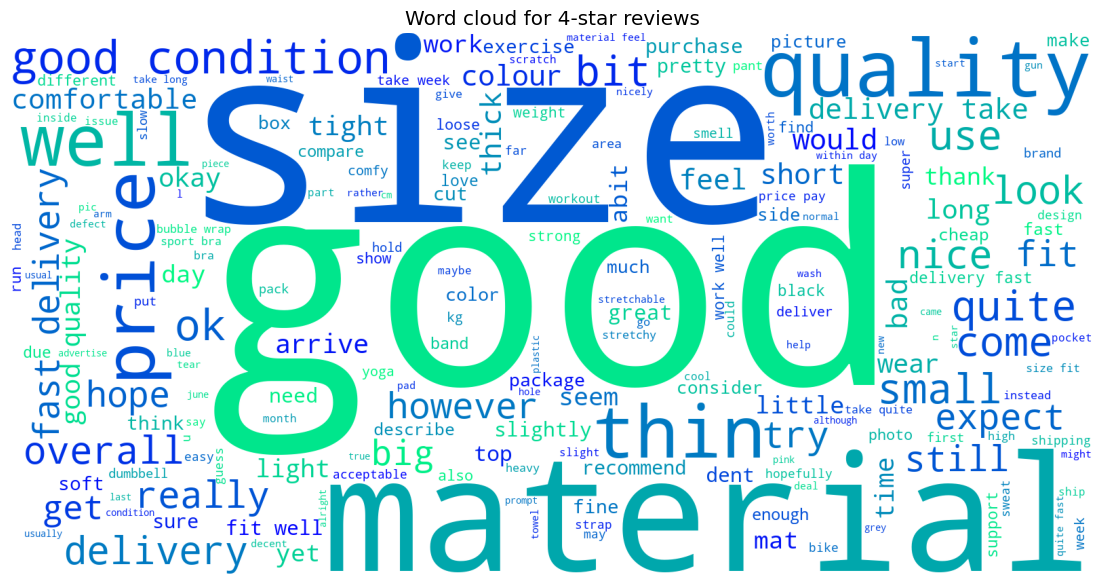

In [127]:
all_fourstar_reviews = " ".join(review for review in fourstar_reviews['cleaned_reviews'])

pos_stopwords = set(stop_words)
pos_stopwords.update({
    'seller',
    'item', 'product', 'items',
    'received', 'receive',
    'ordered', 'Ordered', 'buy','order',
    'one',
    'though', 'even', 'like'
    
})

print('{0} total words in {1} 4-star reviews'.format(len(all_fourstar_reviews), len(fourstar_reviews)))

fourstar_word_cloud = WordCloud(width=1600,
                                height=800,
                                background_color='white',
                                colormap='winter',
                                stopwords=pos_stopwords).generate(all_fourstar_reviews)

fig, axes = plt.subplots(figsize=(14, 8))
axes.imshow(fourstar_word_cloud)
axes.set_title('Word cloud for 4-star reviews')
axes.axis('off')

plt.show()

#### 3-star

30014 total words in 332 3-star reviews


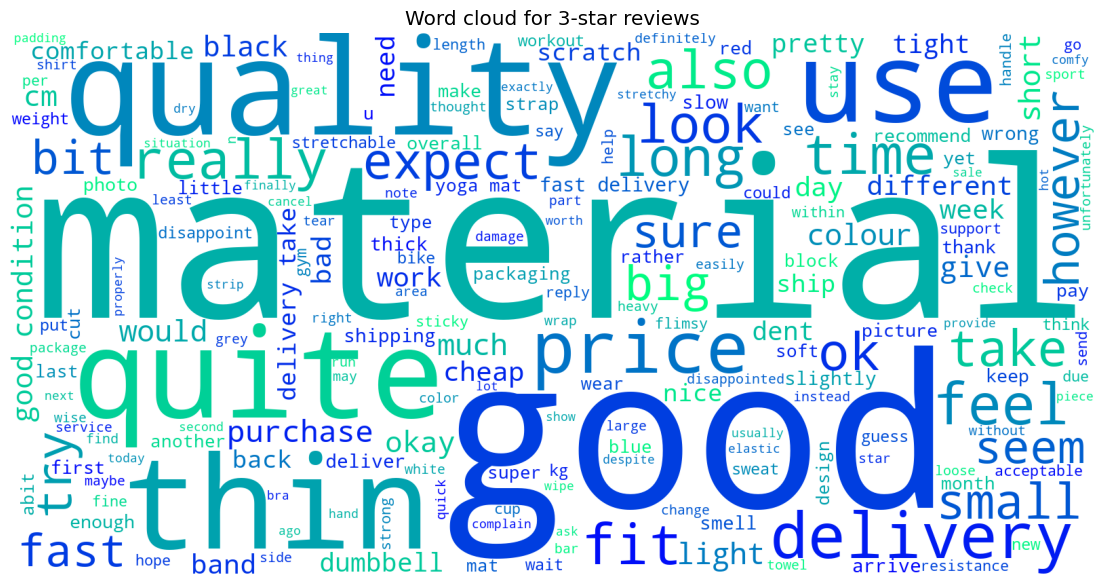

In [130]:
all_threestar_reviews = " ".join(review for review in threestar_reviews['cleaned_reviews'])

pos_stopwords = set(stop_words)
pos_stopwords.update({
    'seller',
    'item', 'product', 'items', 'size',
    'received', 'receive',
    'ordered', 'Ordered', 'buy', 'order',
    'one','come','well',
    'though', 'even', 'like',
    'alsotake', 'still', 'get',
    
})

print('{0} total words in {1} 3-star reviews'.format(len(all_threestar_reviews), len(threestar_reviews)))

threestar_word_cloud = WordCloud(width=1600,
                                height=800,
                                background_color='white',
                                colormap='winter',
                                stopwords=pos_stopwords).generate(all_threestar_reviews)

fig, axes = plt.subplots(figsize=(14, 8))
axes.imshow(threestar_word_cloud)
axes.set_title('Word cloud for 3-star reviews')
axes.axis('off')

plt.show()

#### 2-star

13451 total words in 127 2-star reviews


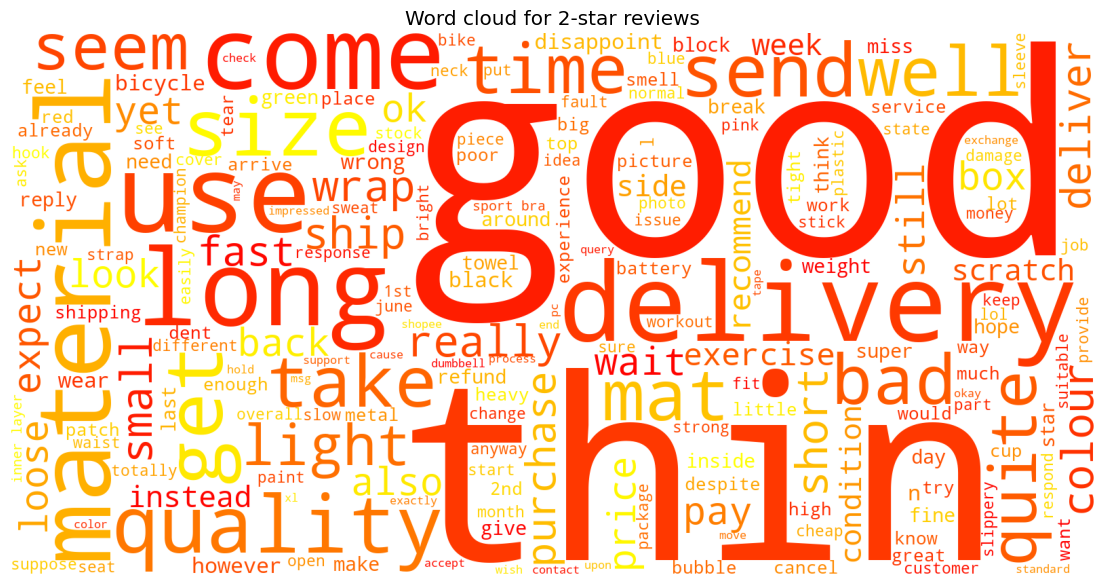

In [111]:
all_twostar_reviews = " ".join(review for review in twostar_reviews['cleaned_reviews'])

pos_stopwords = set(stop_words)
pos_stopwords.update({
    'seller',
    'item', 'product', 'items',
    'received', 'receive',
    'ordered', 'Ordered', 'buy', 'order',
    'one',
    'though', 'even', 'like'
    
})

print('{0} total words in {1} 2-star reviews'.format(len(all_twostar_reviews), len(twostar_reviews)))

twostar_word_cloud = WordCloud(width=1600,
                                height=800,
                                background_color='white',
                                colormap='autumn',
                                stopwords=pos_stopwords).generate(all_twostar_reviews)

fig, axes = plt.subplots(figsize=(14, 8))
axes.imshow(twostar_word_cloud)
axes.set_title('Word cloud for 2-star reviews')
axes.axis('off')

plt.show()

#### 1-star

18946 total words in 165 1-star reviews


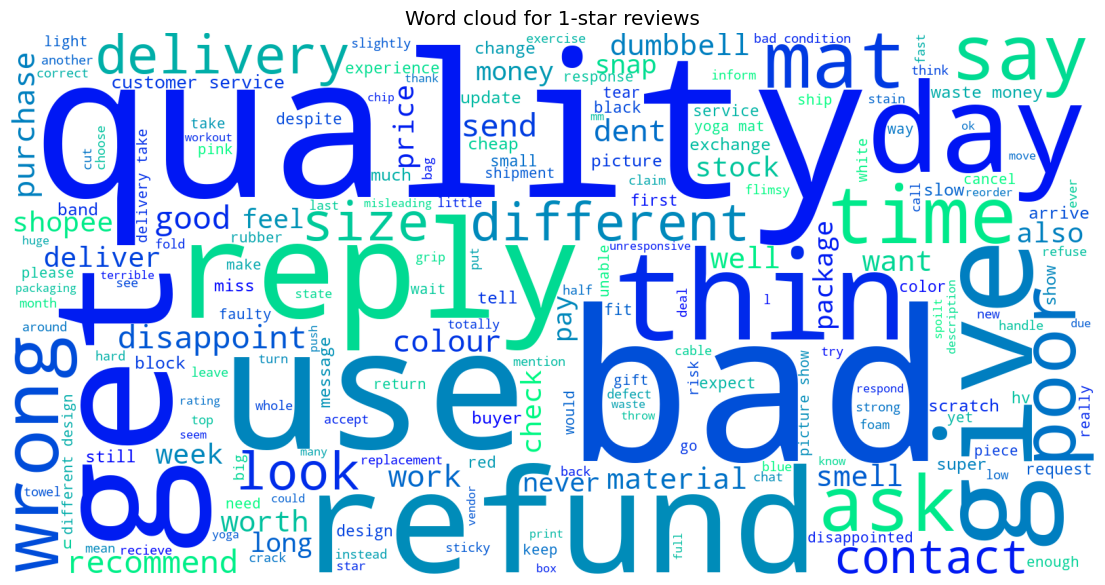

In [103]:
all_onestar_reviews = " ".join(review for review in onestar_reviews['cleaned_reviews'])

neg_stopwords = set(stop_words)
neg_stopwords.update({
    'seller',
    'item', 'product', 'items',
    'received', 'receive',
    'ordered', 'order', 'buy',
    'one', 'come',
    'though', 'even', 'like',
    
})

print('{0} total words in {1} 1-star reviews'.format(len(all_onestar_reviews), len(onestar_reviews)))

onestar_word_cloud = WordCloud(width=1600,
                                height=800,
                                background_color='white',
                                colormap='winter',
                                stopwords=neg_stopwords).generate(all_onestar_reviews)

fig, axes = plt.subplots(figsize=(14, 8))
axes.imshow(onestar_word_cloud)
axes.set_title('Word cloud for 1-star reviews')
axes.axis('off')

plt.show()

## VADER Analysis on 10k reviews

In [114]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jaz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [115]:
sia = SentimentIntensityAnalyzer()

def vader_sentiment_polarity(text):
    senti = sia.polarity_scores(text)
    return senti

In [117]:
ten_k.loc[:,'sentiment_polarity'] = ten_k['cleaned_reviews'].apply(vader_sentiment_polarity)
ten_k

label                                               text  emoji_count  \
0         5  Not bad for its price. Deliver within 2 days. ...            0   
1         5  Delivered within 1 week. Item true to picture ...            0   
2         5   Fast delivery, looks good.  Thanks to the del...            0   
3         5  order arrived within a week well packaged. jus...            0   
4         5  Material is good. Certainly feels like the sta...            0   
...     ...                                                ...          ...   
9995      5  This was taken after a 20 Km trip. Wonderful. ...            0   
9996      5  Very very good service.  Condition of bike is ...            0   
9997      5  Very fast delivery, received item within 15 ho...            0   
9998      5  Order received in excellent condition. Ordered...            0   
9999      5  Very fast deliver, and looks good too! Cant wa...            0   

      word_count  char_count  \
0             11          61   
1             16          91   
2             15          86   
3             29         152   
4             12          79   
...          ...         ...   
9995          49         283   
9996           9          52   
9997          10          65   
9998          22         127   
9999          12          59   

                                        cleaned_reviews  y_pred_nb_ten_k  \
0     not bad price . deliver within 2 day . will re...              1.0   
1     deliver within 1 week . true to picture shop ....              1.0   
2     fast delivery , look good . thank to delivery ...              1.0   
3     order arrive within week well package . just b...              1.0   
4     material good . certainly feel like state weig...              1.0   
...                                                 ...              ...   
9995  take 20 km trip . wonderful . may squeaky soun...              1.0   
9996                good service . condition bike super              1.0   
9997  fast delivery , receive within 15 hour purchase .              1.0   
9998  order receive excellent condition . order 1 pm...              1.0   
9999  fast deliver , look good ! can not wait to try...              0.0   

      not_tried                                 sentiment_polarity  
0         False  {'neg': 0.0, 'neu': 0.529, 'pos': 0.471, 'comp...  
1         False  {'neg': 0.0, 'neu': 0.535, 'pos': 0.465, 'comp...  
2         False  {'neg': 0.088, 'neu': 0.544, 'pos': 0.367, 'co...  
3         False  {'neg': 0.14, 'neu': 0.483, 'pos': 0.377, 'com...  
4         False  {'neg': 0.0, 'neu': 0.339, 'pos': 0.661, 'comp...  
...         ...                                                ...  
9995      False  {'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'comp...  
9996      False  {'neg': 0.0, 'neu': 0.306, 'pos': 0.694, 'comp...  
9997      False  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
9998      False  {'neg': 0.0, 'neu': 0.598, 'pos': 0.402, 'comp...  
9999       True  {'neg': 0.0, 'neu': 0.715, 'pos': 0.285, 'comp...  

[10000 rows x 9 columns]

### Extract scores into columns

In [118]:
ten_k.loc[:,['neg','neu','pos','compound']] = ten_k['sentiment_polarity'].apply(pd.Series)
ten_k

label                                               text  emoji_count  \
0         5  Not bad for its price. Deliver within 2 days. ...            0   
1         5  Delivered within 1 week. Item true to picture ...            0   
2         5   Fast delivery, looks good.  Thanks to the del...            0   
3         5  order arrived within a week well packaged. jus...            0   
4         5  Material is good. Certainly feels like the sta...            0   
...     ...                                                ...          ...   
9995      5  This was taken after a 20 Km trip. Wonderful. ...            0   
9996      5  Very very good service.  Condition of bike is ...            0   
9997      5  Very fast delivery, received item within 15 ho...            0   
9998      5  Order received in excellent condition. Ordered...            0   
9999      5  Very fast deliver, and looks good too! Cant wa...            0   

      word_count  char_count  \
0             11          61   
1             16          91   
2             15          86   
3             29         152   
4             12          79   
...          ...         ...   
9995          49         283   
9996           9          52   
9997          10          65   
9998          22         127   
9999          12          59   

                                        cleaned_reviews  y_pred_nb_ten_k  \
0     not bad price . deliver within 2 day . will re...              1.0   
1     deliver within 1 week . true to picture shop ....              1.0   
2     fast delivery , look good . thank to delivery ...              1.0   
3     order arrive within week well package . just b...              1.0   
4     material good . certainly feel like state weig...              1.0   
...                                                 ...              ...   
9995  take 20 km trip . wonderful . may squeaky soun...              1.0   
9996                good service . condition bike super              1.0   
9997  fast delivery , receive within 15 hour purchase .              1.0   
9998  order receive excellent condition . order 1 pm...              1.0   
9999  fast deliver , look good ! can not wait to try...              0.0   

      not_tried                                 sentiment_polarity    neg  \
0         False  {'neg': 0.0, 'neu': 0.529, 'pos': 0.471, 'comp...  0.000   
1         False  {'neg': 0.0, 'neu': 0.535, 'pos': 0.465, 'comp...  0.000   
2         False  {'neg': 0.088, 'neu': 0.544, 'pos': 0.367, 'co...  0.088   
3         False  {'neg': 0.14, 'neu': 0.483, 'pos': 0.377, 'com...  0.140   
4         False  {'neg': 0.0, 'neu': 0.339, 'pos': 0.661, 'comp...  0.000   
...         ...                                                ...    ...   
9995      False  {'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'comp...  0.000   
9996      False  {'neg': 0.0, 'neu': 0.306, 'pos': 0.694, 'comp...  0.000   
9997      False  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000   
9998      False  {'neg': 0.0, 'neu': 0.598, 'pos': 0.402, 'comp...  0.000   
9999       True  {'neg': 0.0, 'neu': 0.715, 'pos': 0.285, 'comp...  0.000   

        neu    pos  compound  
0     0.529  0.471    0.6542  
1     0.535  0.465    0.8271  
2     0.544  0.367    0.6249  
3     0.483  0.377    0.7500  
4     0.339  0.661    0.8934  
...     ...    ...       ...  
9995  0.744  0.256    0.8226  
9996  0.306  0.694    0.7783  
9997  1.000  0.000    0.0000  
9998  0.598  0.402    0.8126  
9999  0.715  0.285    0.4926  

[10000 rows x 13 columns]

In [ ]:
import seaborn as sns

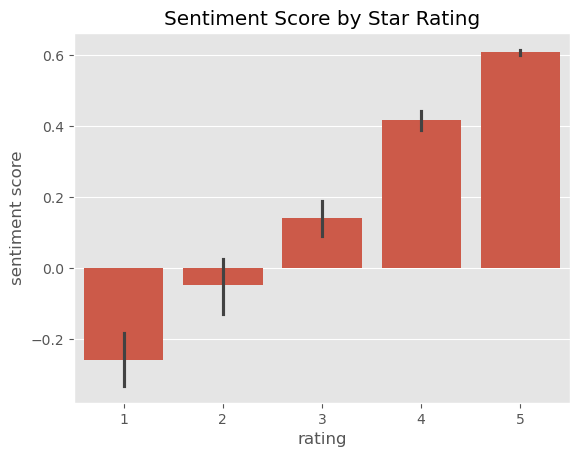

In [119]:
fig_1 = sns.barplot(data=ten_k, x='label', y='compound')
fig_1.set_title('Sentiment Score by Star Rating')
plt.xlabel('rating')
plt.ylabel('sentiment score')
plt.show()

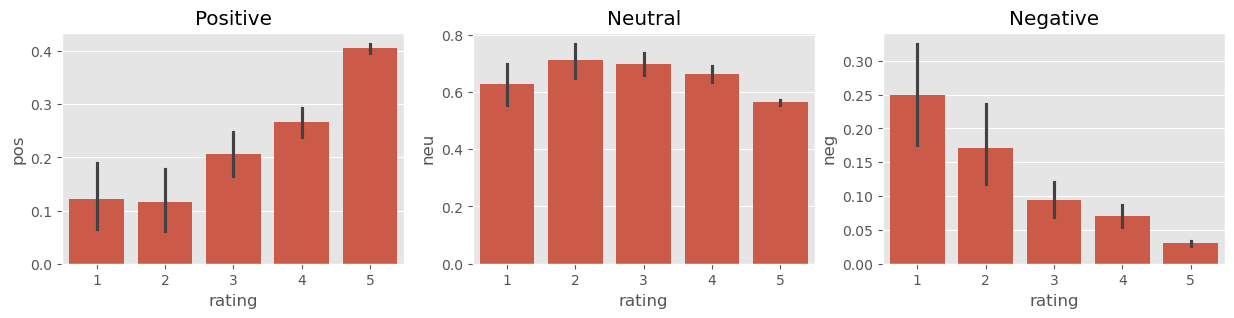

In [120]:
fig_2, axs = plt.subplots(1, 3, figsize=(15,3))
sns.barplot(data=corrected_sample, x='label', y='pos', ax=axs[0])
sns.barplot(data=corrected_sample, x='label', y='neu', ax=axs[1])
sns.barplot(data=corrected_sample, x='label', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[0].set_xlabel('rating')

axs[1].set_title('Neutral')
axs[1].set_xlabel('rating')

axs[2].set_title('Negative')
axs[2].set_xlabel('rating')

plt.show()

In [123]:
positive_reviews = ten_k[ten_k['compound'] > 0]
neutral_reviews = ten_k[ten_k['compound'] == 0]
negative_reviews = ten_k[ten_k['compound'] < 0]

715960 total words in 8707 positive reviews


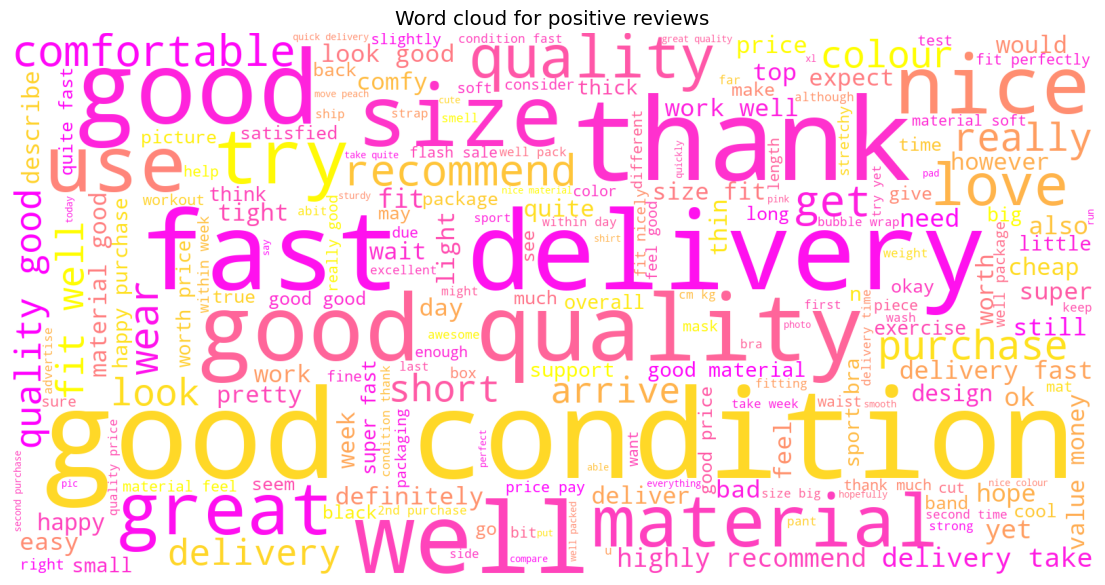

In [124]:
all_positive_reviews = " ".join(review for review in positive_reviews['cleaned_reviews'])

wc_stopwords = set(stop_words)
wc_stopwords.update({
    'seller',
    'item', 'product', 'items',
    'received', 'receive',
    'ordered', 'order', 'buy',
    'one', 'come',
    'though', 'even', 'like',
    
})

print('{0} total words in {1} positive reviews'.format(len(all_positive_reviews), len(positive_reviews)))

positive_word_cloud = WordCloud(width=1600,
                                height=800,
                                background_color='white',
                                colormap='spring',
                                stopwords=wc_stopwords).generate(all_positive_reviews)

fig, axes = plt.subplots(figsize=(14, 8))
axes.imshow(positive_word_cloud)
axes.set_title('Word cloud for positive reviews')
axes.axis('off')

plt.show()

34928 total words in 574 neutral reviews


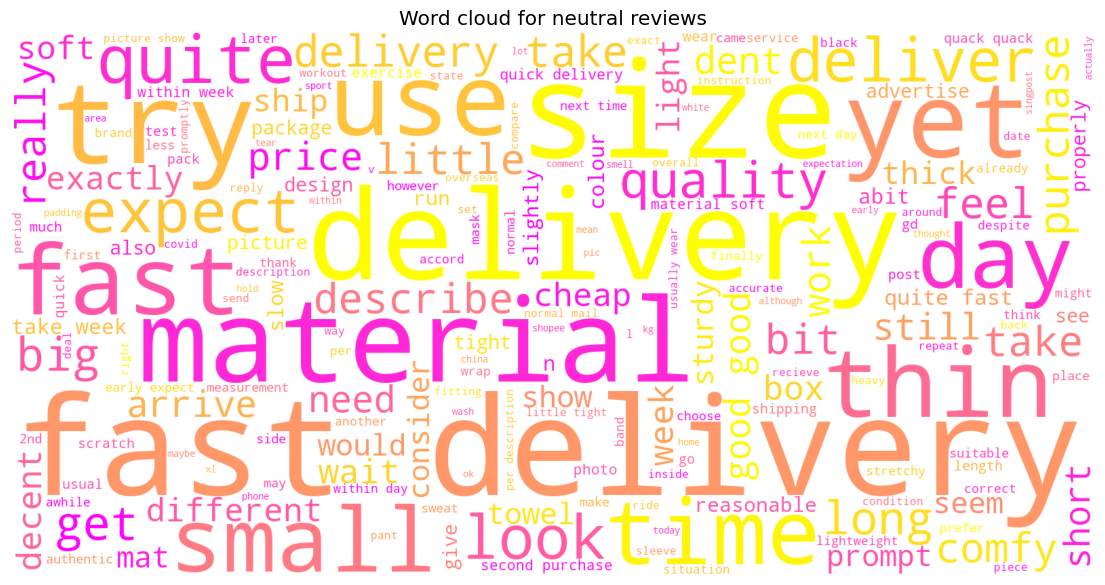

In [125]:
all_neutral_reviews = " ".join(review for review in neutral_reviews['cleaned_reviews'])

wc_stopwords = set(stop_words)
wc_stopwords.update({
    'seller',
    'item', 'product', 'items',
    'received', 'receive',
    'ordered', 'order', 'buy',
    'one', 'come',
    'though', 'even', 'like',
    
})

print('{0} total words in {1} neutral reviews'.format(len(all_neutral_reviews), len(neutral_reviews)))

neutral_word_cloud = WordCloud(width=1600,
                                height=800,
                                background_color='white',
                                colormap='spring',
                                stopwords=wc_stopwords).generate(all_neutral_reviews)

fig, axes = plt.subplots(figsize=(14, 8))
axes.imshow(neutral_word_cloud)
axes.set_title('Word cloud for neutral reviews')
axes.axis('off')

plt.show()

66574 total words in 719 negative reviews


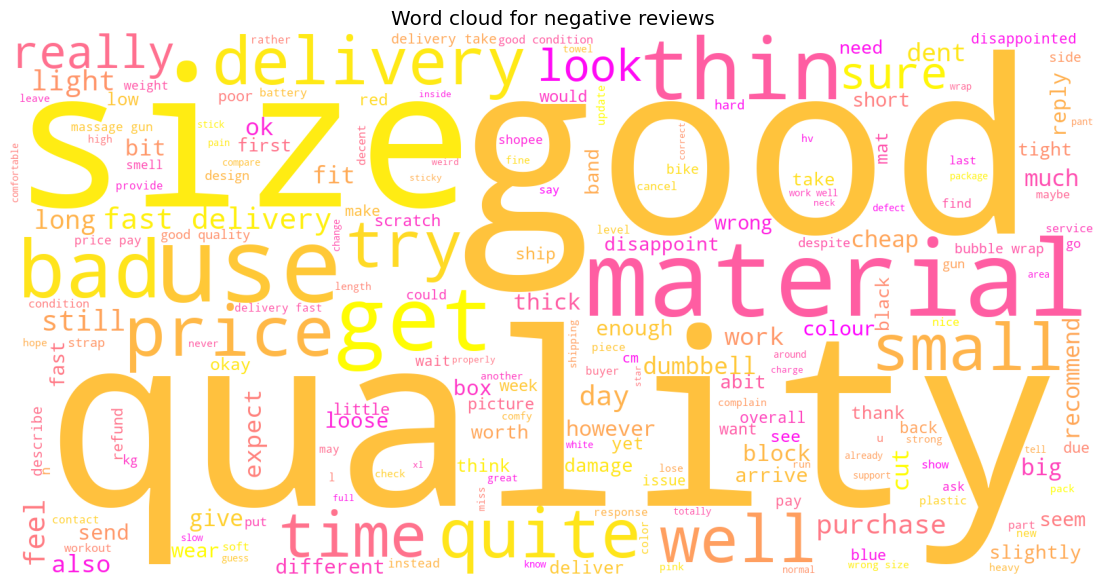

In [126]:
all_negative_reviews = " ".join(review for review in negative_reviews['cleaned_reviews'])

wc_stopwords = set(stop_words)
wc_stopwords.update({
    'seller',
    'item', 'product', 'items',
    'received', 'receive',
    'ordered', 'order', 'buy',
    'one', 'come',
    'though', 'even', 'like',
    
})

print('{0} total words in {1} negative reviews'.format(len(all_negative_reviews), len(negative_reviews)))

negative_word_cloud = WordCloud(width=1600,
                                height=800,
                                background_color='white',
                                colormap='spring',
                                stopwords=wc_stopwords).generate(all_negative_reviews)

fig, axes = plt.subplots(figsize=(14, 8))
axes.imshow(negative_word_cloud)
axes.set_title('Word cloud for negative reviews')
axes.axis('off')

plt.show()